# Analysis for SSFA project: Three factor  model
# Filtered strongly by < 5% NMP

## Table of contents
1. [Used packages](#imports)
1. [Global settings](#settings)
1. [Load data](#load)
1. [Explore data](#exploration)
1. [Model specification](#model)
1. [Inference](#inference)
   1. [epLsar](#epLsar)
   1. [R²](#r)
   1. [Asfc](#Asfc)
   1. [Smfc](#Smfc)
   1. [HAsfc9](#HAsfc9)
1. [Summary](#summary)

## Used packages <a name="imports"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
import arviz as az
import pymc3 as pm

In [2]:
from matplotlib.colors import to_rgb

In [3]:
import scipy.stats as stats 

In [4]:
from IPython.display import display

In [5]:
import matplotlib as mpl

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import plotting_lib

## Global settings <a name="settings"></a>

#### Output

In [8]:
writeOut = True
outPathPlots = "../plots/statistical_model_three_factors_filter_strong/"
outPathData = "../derived_data/statistical_model_three_factors_filter_strong/"
prefix = "ThreeFactor_filter_strong"

#### Plotting

In [9]:
widthMM = 190 
widthInch = widthMM / 25.4
ratio = 0.66666
heigthInch = ratio*widthInch

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")

dpi = 300

In [10]:
sizes = [SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE]

#### Computing

In [11]:
numSamples = 1000
numCores = 4
numTune = 1000
numPredSamples = 2000
random_seed=36514535
target_accept = 0.99

## Load data <a name="load"></a>

In [12]:
datafile = "../derived_data/preprocessing/preprocessed_filter_strong.dat"

In [13]:
with open(datafile, "rb") as f:
    x1,x2,x3,df,dataZ,dictMeanStd,dictTreatment,dictSoftware = pickle.load(f)    

Show that everything is correct:

In [14]:
display(pd.DataFrame.from_dict({'x1':x1,'x2':x2,'x3':x3}))

x1  x2   x3
0     0   5   98
1     1   5   98
2     0   5   99
3     1   5   99
4     0   5  100
..   ..  ..  ...
225   1   9   52
226   0   9   53
227   1   9   53
228   0   9   54
229   1   9   54

[230 rows x 3 columns]

x1 indicates the software used, x2 indicates the treatment applied and x3 the sample.

In [15]:
for surfaceParam,(mean,std) in dictMeanStd.items():
    print("Surface parameter {} has mean {} and standard deviation {}".format(surfaceParam,mean,std))

Surface parameter epLsar has mean 0.0033908522378621737 and standard deviation 0.001989767613698366
Surface parameter Rsquared has mean 0.9973621855273914 and standard deviation 0.007969957191822462
Surface parameter Asfc has mean 13.800529685456086 and standard deviation 12.970336908999228
Surface parameter Smfc has mean 1.350346875497435 and standard deviation 7.832927757231397
Surface parameter HAsfc9 has mean 0.4835258022408901 and standard deviation 0.8643524891543747
Surface parameter HAsfc81 has mean 1.0354777484507558 and standard deviation 2.586788670504154


In [16]:
for k,v in sorted(dictTreatment.items(), key=lambda x: x[0]):    
    print("Number {} encodes treatment {}".format(k,v))

Number 0 encodes treatment BrushDirt
Number 1 encodes treatment BrushNoDirt
Number 2 encodes treatment Clover
Number 3 encodes treatment Clover+dust
Number 4 encodes treatment Control
Number 5 encodes treatment Dry bamboo
Number 6 encodes treatment Dry grass
Number 7 encodes treatment Dry lucerne
Number 8 encodes treatment Grass
Number 9 encodes treatment Grass+dust
Number 10 encodes treatment RubDirt


In [17]:
for k,v in dictSoftware.items():
    print("Number {} encodes software {}".format(k,v))

Number 0 encodes software ConfoMap
Number 1 encodes software Toothfrax


In [18]:
display(dataZ)

index  TreatmentNumber  SoftwareNumber  DatasetNumber  NameNumber  \
0        0                5               0              0          98   
1        1                5               1              0          98   
2        2                5               0              0          99   
3        3                5               1              0          99   
4        4                5               0              0         100   
..     ...              ...             ...            ...         ...   
225    225                9               1              2          52   
226    226                9               0              2          53   
227    227                9               1              2          53   
228    228                9               0              2          54   
229    229                9               1              2          54   

     epLsar_z  Rsquared_z    Asfc_z    Smfc_z  HAsfc9_z  HAsfc81_z  
0    0.515753    0.080435 -0.165334 -0.134789 -0.402292  -0.259843  
1    0.668494    0.275762 -0.268289 -0.157173 -0.402677  -0.260418  
2    1.243847   -0.146130  0.128490 -0.134789 -0.360528  -0.285754  
3    1.238912    0.264094 -0.046359 -0.157173 -0.363618  -0.299313  
4    0.829617   -0.323025 -0.046215 -0.134789 -0.257176  -0.243567  
..        ...         ...       ...       ...       ...        ...  
225  0.519230    0.250668 -0.923702  0.007447  0.408438   0.029468  
226  0.005954    0.186666 -0.843131 -0.110277  0.178138   0.194629  
227 -0.126574    0.298222 -0.851345 -0.155367  0.546274   0.307811  
228 -1.091196    0.265539 -0.949772 -0.014439 -0.130543  -0.089431  
229 -1.350837    0.313027 -0.953590 -0.120251 -0.158980  -0.075589  

[230 rows x 11 columns]

In [19]:
display(df)

Dataset                            Name   Software        Diet  \
0    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_1   ConfoMap  Dry bamboo   
1    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_1  Toothfrax  Dry bamboo   
2    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_2   ConfoMap  Dry bamboo   
3    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_2  Toothfrax  Dry bamboo   
4    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_3   ConfoMap  Dry bamboo   
..          ...                             ...        ...         ...   
225      Sheeps          L8-Ovis-90730-lm2sin-a  Toothfrax  Grass+dust   
226      Sheeps          L8-Ovis-90764-lm2sin-a   ConfoMap  Grass+dust   
227      Sheeps          L8-Ovis-90764-lm2sin-a  Toothfrax  Grass+dust   
228      Sheeps          L8-Ovis-90814-lm2sin-a   ConfoMap  Grass+dust   
229      Sheeps          L8-Ovis-90814-lm2sin-a  Toothfrax  Grass+dust   

      Treatment Before.after       NMP NMP_cat    epLsar  Rsquared       Asfc  \
0    Dry bamboo          NaN  0.717312    0-5%  0.004417  0.998003  11.656095   
1    Dry bamboo          NaN  0.717312    0-5%  0.004721  0.999560  10.320730   
2    Dry bamboo          NaN  1.674215    0-5%  0.005866  0.996198  15.467083   
3    Dry bamboo          NaN  1.674215    0-5%  0.005856  0.999467  13.199232   
4    Dry bamboo          NaN  1.760409    0-5%  0.005042  0.994788  13.201101   
..          ...          ...       ...     ...       ...       ...        ...   
225  Grass+dust          NaN  0.000000    0-5%  0.004424  0.999360   1.819802   
226  Grass+dust          NaN  0.000000    0-5%  0.003403  0.998850   2.864831   
227  Grass+dust          NaN  0.000000    0-5%  0.003139  0.999739   2.758297   
228  Grass+dust          NaN  0.000000    0-5%  0.001220  0.999479   1.481662   
229  Grass+dust          NaN  0.000000    0-5%  0.000703  0.999857   1.432148   

         Smfc    HAsfc9   HAsfc81  NewEplsar  TreatmentNumber  SoftwareNumber  \
0    0.294557  0.135803  0.363319   0.019460                5               0   
1    0.119219  0.135471  0.361833        NaN                5               1   
2    0.294557  0.171903  0.296292   0.020079                5               0   
3    0.119219  0.169232  0.261217        NaN                5               1   
4    0.294557  0.261235  0.405422   0.019722                5               0   
..        ...       ...       ...        ...              ...             ...   
225  1.408678  0.836560  1.111706        NaN                9               1   
226  0.486556  0.637499  1.538943   0.018978                9               0   
227  0.133366  0.955699  1.831721        NaN                9               1   
228  1.237247  0.370691  0.804138   0.017498                9               0   
229  0.408433  0.346111  0.839946        NaN                9               1   

     DatasetNumber  NameNumber  
0                0          98  
1                0          98  
2                0          99  
3                0          99  
4                0         100  
..             ...         ...  
225              2          52  
226              2          53  
227              2          53  
228              2          54  
229              2          54  

[230 rows x 19 columns]

#### Contrasts
Prepare dicts for contrasts that are of interest later.

In [20]:
x1contrast_dict = {'{}_{}'.format(dictSoftware[0],dictSoftware[1]):[1,-1]}
x1contrast_dict

{'ConfoMap_Toothfrax': [1, -1]}

## Explore data <a name="exploration"></a>

#### Compute raw differences

In [21]:
dfRawDiff = dataZ.groupby(['DatasetNumber','TreatmentNumber','NameNumber']).agg(list).applymap(lambda l : l[0]-l[1]).reset_index()

In [22]:
dfRawDiff

DatasetNumber  TreatmentNumber  NameNumber  index  SoftwareNumber  \
0                0                5          98     -1              -1   
1                0                5          99     -1              -1   
2                0                5         100     -1              -1   
3                0                5         101     -1              -1   
4                0                5         102     -1              -1   
..             ...              ...         ...    ...             ...   
110              2                9          50     -1              -1   
111              2                9          51     -1              -1   
112              2                9          52     -1              -1   
113              2                9          53     -1              -1   
114              2                9          54     -1              -1   

     epLsar_z  Rsquared_z    Asfc_z    Smfc_z  HAsfc9_z  HAsfc81_z  
0   -0.152741   -0.195327  0.102955  0.022385  0.000385   0.000575  
1    0.004935   -0.410224  0.174849  0.022385  0.003090   0.013559  
2    0.133482   -0.562275  0.165059  0.022385  0.050717   0.018889  
3    0.354001   -0.347736  0.198535  0.026957  0.016939  -0.032803  
4   -0.024548   -0.495939  0.191016  0.020288 -0.043304   0.020445  
..        ...         ...       ...       ...       ...        ...  
110  0.550478   -0.152354  0.136512  0.014851  0.050951   0.042694  
111  1.650091   -0.143020  0.020892  0.014851  0.408637   0.129269  
112 -2.054742   -0.318156  0.000641  0.355427 -0.009580   0.004557  
113  0.132528   -0.111556  0.008214  0.045090 -0.368137  -0.113182  
114  0.259641   -0.047488  0.003818  0.105812  0.028437  -0.013843  

[115 rows x 11 columns]

#### Show difference between software in raw data

In [23]:
variablesList = ['epLsar','Rsquared','Asfc','Smfc','HAsfc9']

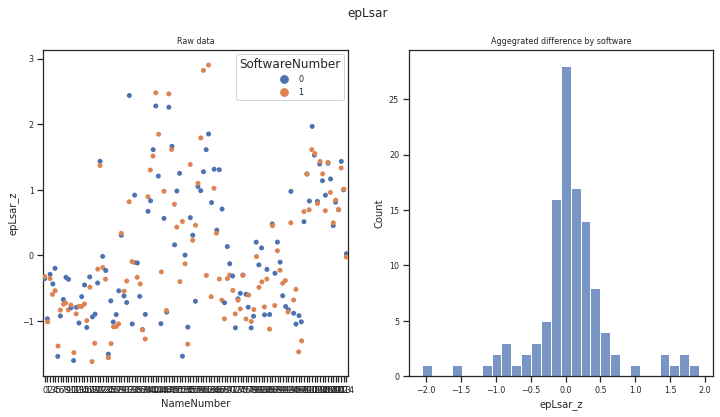

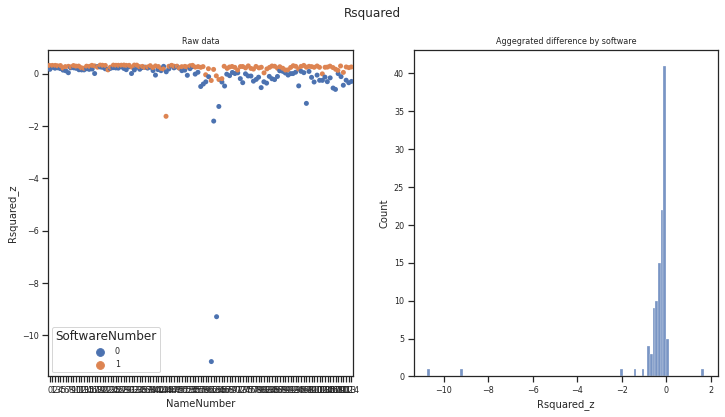

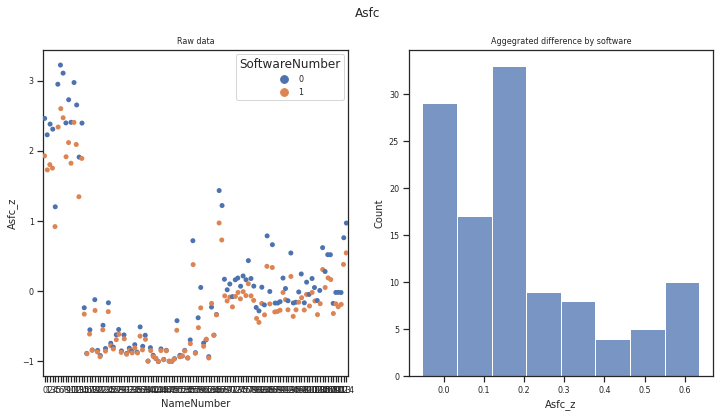

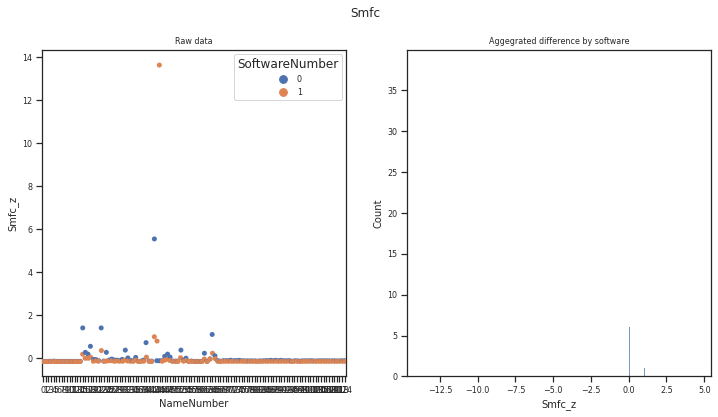

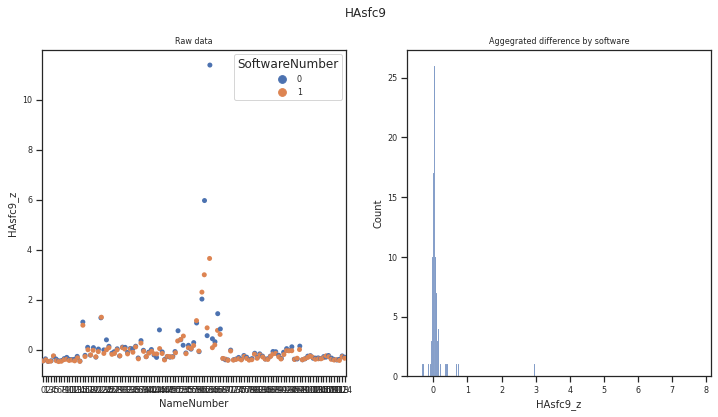

In [24]:
for var in variablesList:
    fig, axes = plt.subplots(1, 2,figsize=(12,6))
    fig.suptitle('{}'.format(var))

    
    sns.stripplot(data=dataZ,x='NameNumber',y='{}_z'.format(var),hue='SoftwareNumber',ax=axes[0]);
    axes[0].set_title('Raw data')

    sns.histplot(data=dfRawDiff,x='{}_z'.format(var),ax=axes[1]);
    axes[1].set_title('Aggegrated difference by software'.format(var))

    plt.show()

## Model specification <a name="model"></a>

In [25]:
class ThreeFactorModel(pm.Model):
    
    """
    Compute params of priors and hyperpriors.
    """
    def getParams(self,x1,x2,x3,y):
        # get lengths
        Nx1Lvl = np.unique(x1).size
        Nx2Lvl = np.unique(x2).size
        Nx3Lvl = np.unique(x3).size        
        
        dims = (Nx1Lvl, Nx2Lvl, Nx3Lvl)
        
        ### get standard deviations
        
        # convert to pandas dataframe to use their logic
        df = pd.DataFrame.from_dict({'x1':x1,'x2':x2,'x3':x3,'y':y})
        
        s1 = df.groupby('x1').std()['y'].max()
        s2 = df.groupby('x2').std()['y'].max()
        s3 = df.groupby('x3').std()['y'].max()
        
        stdSingle = (s1, s2, s3)
        
        return (dims, stdSingle)
    
    def printParams(self,x1,x2,x3,y):
        dims, stdSingle = self.getParams(x1,x2,x3,y)
        Nx1Lvl, Nx2Lvl, Nx3Lvl = dims
        s1, s2, s3 = stdSingle        
        
        print("The number of levels of the x variables are {}".format(dims))
        print("The standard deviations used for the beta priors are {}".format(stdSingle))
            
    def __init__(self,name,x1,x2,x3,y,model=None):
        
        # call super's init first, passing model and name
        super().__init__(name, model)
        
        # get parameter of hyperpriors
        dims, stdSingle = self.getParams(x1,x2,x3,y)
        Nx1Lvl, Nx2Lvl, Nx3Lvl = dims
        s1, s2, s3 = stdSingle        
        
        ### hyperpriors ### 
        # observation hyperpriors
        lamY = 1/30.
        muGamma = 0.5
        sigmaGamma = 2.
        
        # prediction hyperpriors
        sigma0 = pm.HalfNormal('sigma0',sd=1)
        sigma1 = pm.HalfNormal('sigma1',sd=s1, shape=Nx1Lvl)
        sigma2 = pm.HalfNormal('sigma2',sd=s2, shape=Nx2Lvl)
        sigma3 = pm.HalfNormal('sigma3',sd=s3, shape=Nx3Lvl)
                
        mu_b0 = pm.Normal('mu_b0', mu=0., sd=1)
        mu_b1 = pm.Normal('mu_b1', mu=0., sd=1, shape=Nx1Lvl)
        mu_b2 = pm.Normal('mu_b2', mu=0., sd=1, shape=Nx2Lvl)
        mu_b3 = pm.Normal('mu_b3', mu=0., sd=1, shape=Nx3Lvl)       
                                       
        ### priors ### 
        # observation priors        
        nuY = pm.Exponential('nuY',lam=lamY)
        sigmaY = pm.Gamma('sigmaY',mu=muGamma, sigma=sigmaGamma)
        
        # prediction priors
        b0_dist = pm.Normal('b0_dist', mu=0, sd=1)
        b0 = pm.Deterministic("b0", mu_b0 + b0_dist * sigma0)
       
        b1_dist = pm.Normal('b1_dist', mu=0, sd=1)
        b1 = pm.Deterministic("b1", mu_b1 + b1_dist * sigma1)
        
        b2_dist = pm.Normal('b2_dist', mu=0, sd=1)
        b2 = pm.Deterministic("b2", mu_b2 + b2_dist * sigma2)
        
        b3_dist = pm.Normal('b3_dist', mu=0, sd=1)
        b3 = pm.Deterministic("b3", mu_b3 + b3_dist * sigma3)
             
        #### prediction ###      
        mu = pm.Deterministic('mu',b0 + b1[x1] + b2[x2] +  b3[x3])

                                
        ### observation ### 
        y = pm.StudentT('y',nu = nuY, mu=mu, sd=sigmaY, observed=y)

## Inference <a name="inference"></a>

### epLsar <a name="epLsar"></a>

In [26]:
with pm.Model() as model:
    epLsarModel = ThreeFactorModel('epLsar',x1,x2,x3,dataZ.epLsar_z.values)

#### Verify model settings

In [27]:
epLsarModel.printParams(x1,x2,x3,dataZ.epLsar_z.values)

The number of levels of the x variables are (2, 11, 115)
The standard deviations used for the beta priors are (1.022692176080412, 1.4502540614172976, 1.4529223548483703)


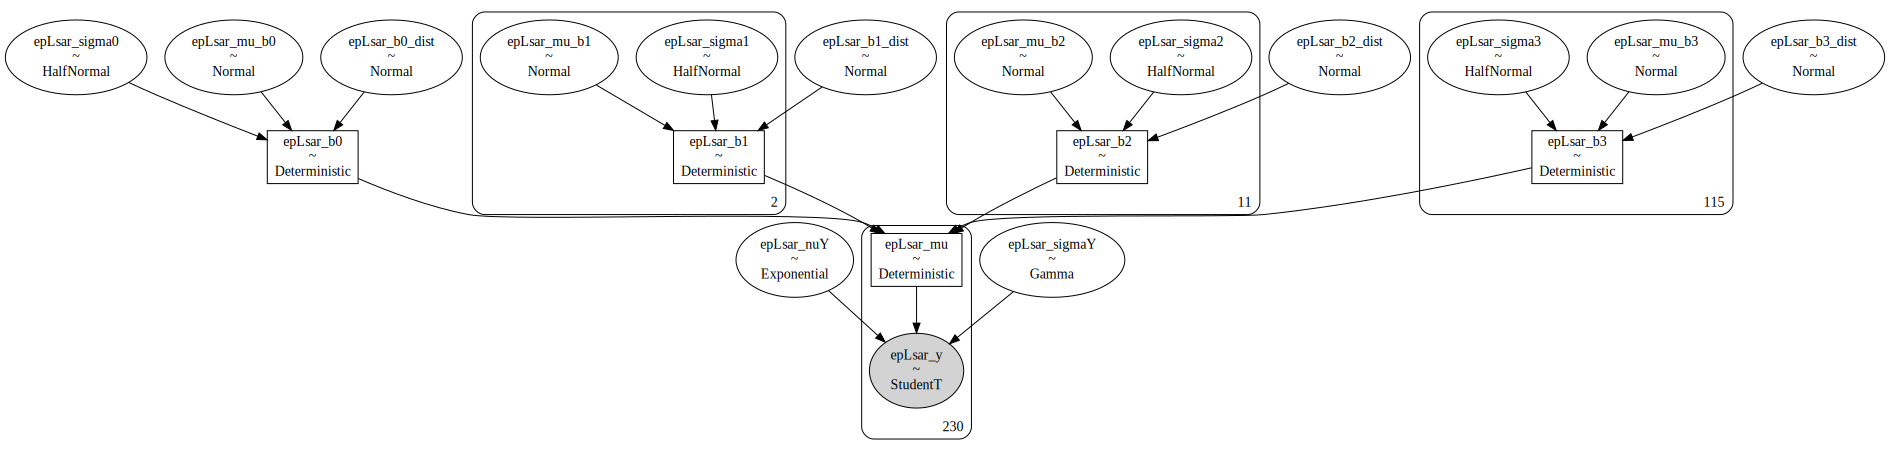

In [28]:
try:
    graph_epLsar = pm.model_to_graphviz(epLsarModel)    
except:
    graph_epLsar = "Could not make graph"
graph_epLsar

#### Check prior choice

In [29]:
with epLsarModel as model:
    prior_pred_epLsar = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

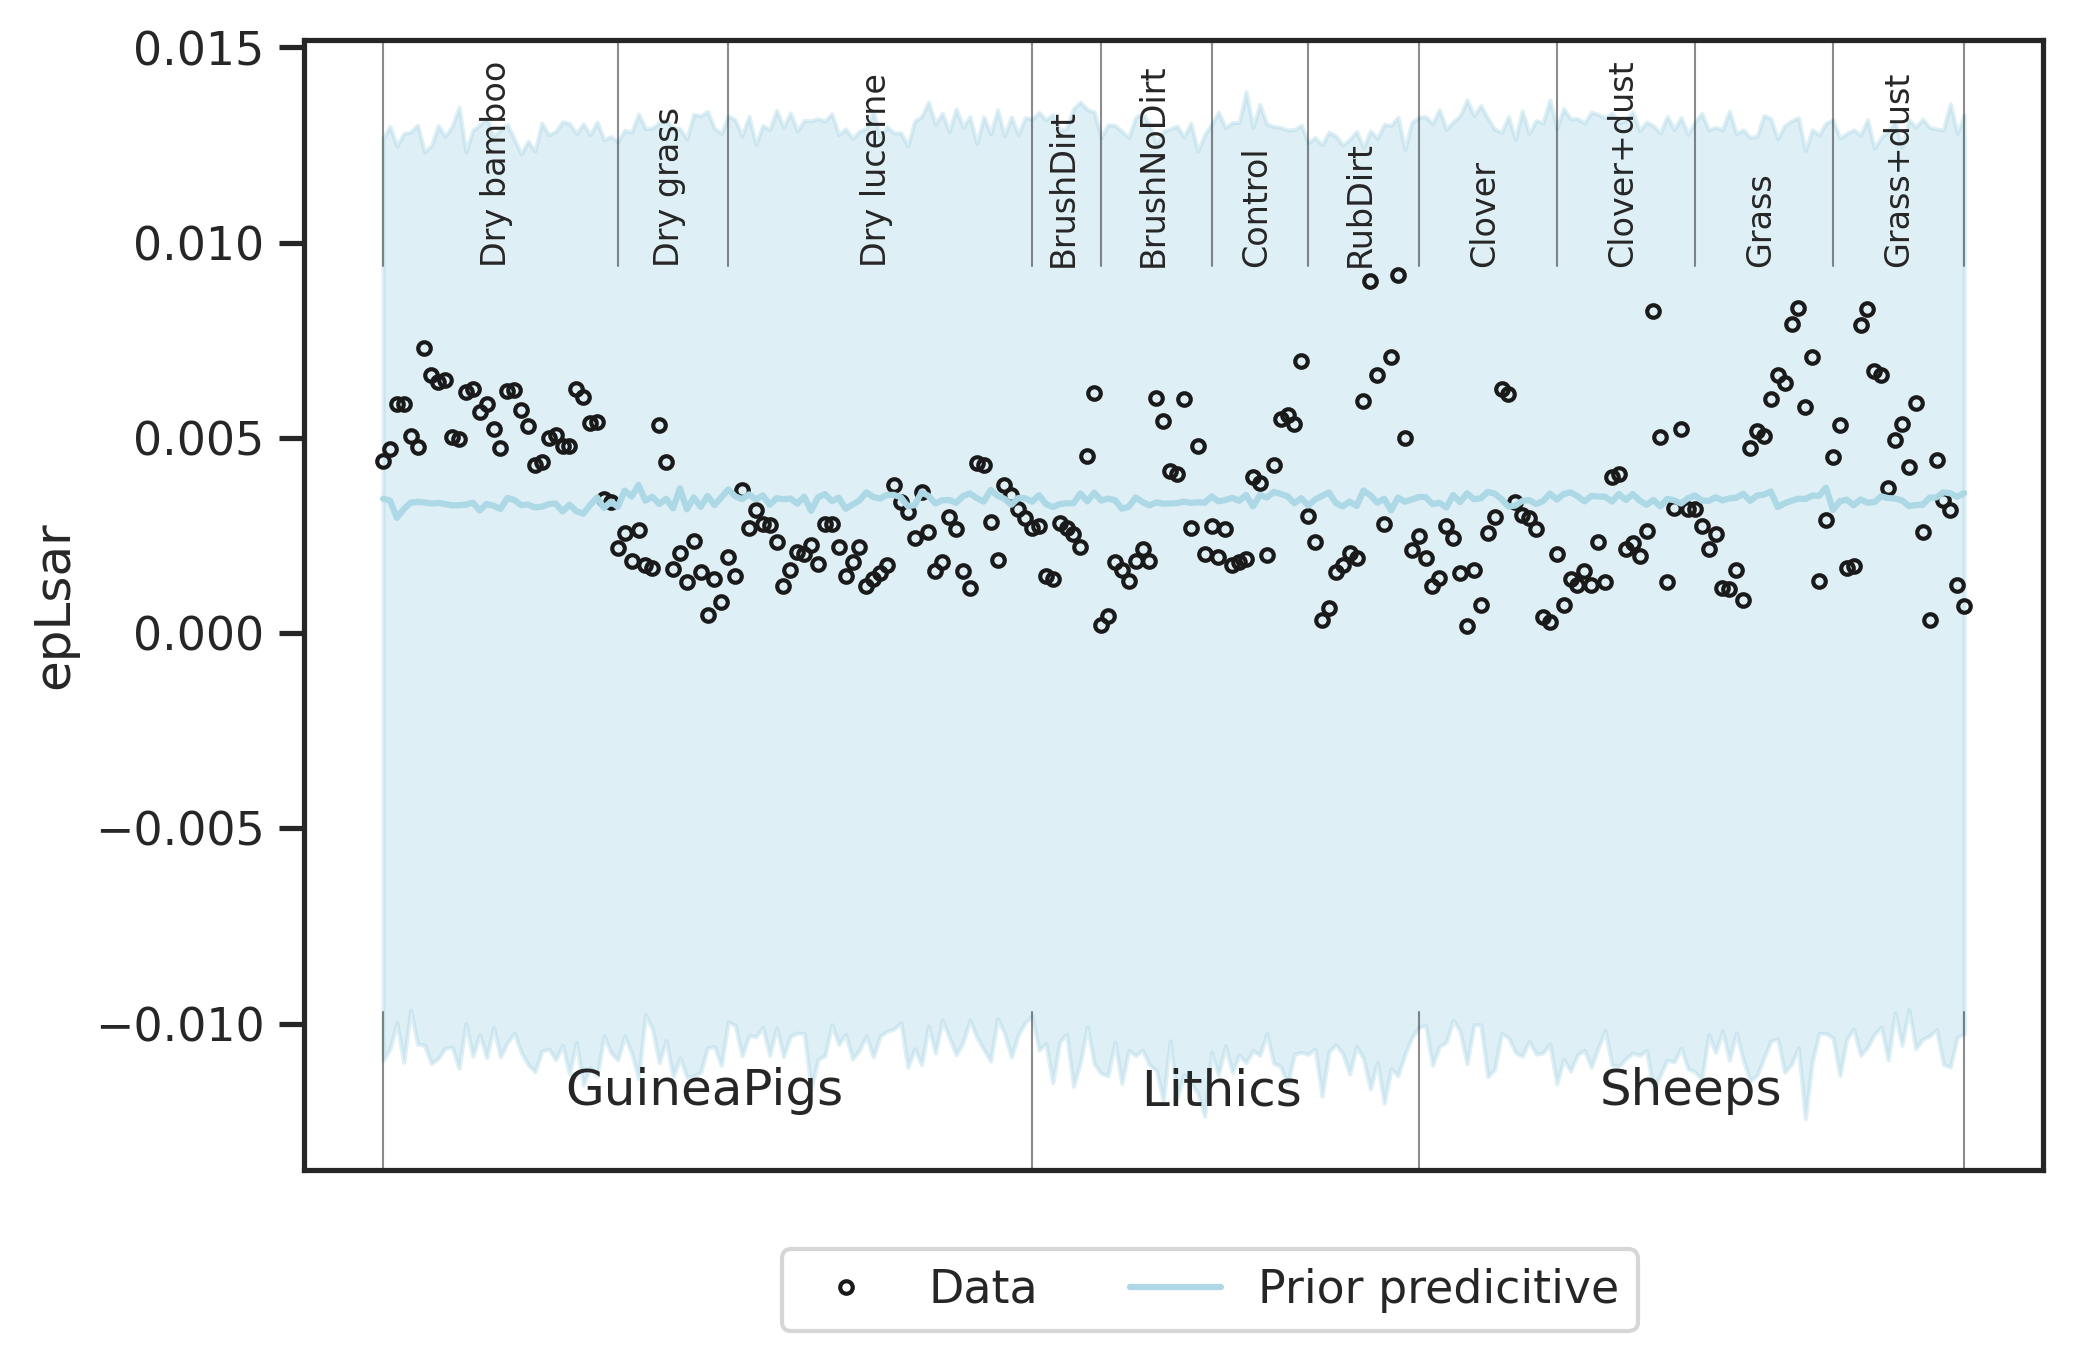

In [32]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,df,dictMeanStd,\
                                 prior_pred_epLsar,dataZ.epLsar_z.values,'epLsar',prefix)

Prior choice is as intended: Broad over the data range.

#### Sampling

In [33]:
with epLsarModel as model:
    trace_epLsar = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=target_accept,random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epLsar_b3_dist, epLsar_b2_dist, epLsar_b1_dist, epLsar_b0_dist, epLsar_sigmaY, epLsar_nuY, epLsar_mu_b3, epLsar_mu_b2, epLsar_mu_b1, epLsar_mu_b0, epLsar_sigma3, epLsar_sigma2, epLsar_sigma1, epLsar_sigma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 576 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [35]:
with epLsarModel as model:
    if writeOut:
        with open(outPathData + '{}_model_{}.pkl'.format(prefix,'epLsar'), 'wb') as buff:
            pickle.dump({'model':epLsarModel, 'trace': trace_epLsar}, buff)

#### Check sampling

In [36]:
with epLsarModel as model:
    dataTrace_epLsar = az.from_pymc3(trace=trace_epLsar)

In [37]:
pm.summary(dataTrace_epLsar,hdi_prob=0.95).round(2)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
epLsar_mu_b0    -0.04  0.81     -1.65       1.54       0.02     0.01   
epLsar_mu_b1[0]  0.01  0.69     -1.35       1.34       0.01     0.01   
epLsar_mu_b1[1] -0.03  0.68     -1.36       1.28       0.01     0.01   
epLsar_mu_b2[0] -0.17  0.55     -1.23       0.94       0.01     0.01   
epLsar_mu_b2[1] -0.21  0.53     -1.26       0.80       0.01     0.01   
...               ...   ...       ...        ...        ...      ...   
epLsar_mu[225]   0.10  0.75     -1.67       0.82       0.04     0.03   
epLsar_mu[226]  -0.03  0.11     -0.24       0.19       0.00     0.00   
epLsar_mu[227]  -0.09  0.11     -0.29       0.14       0.00     0.00   
epLsar_mu[228]  -1.16  0.14     -1.41      -0.89       0.00     0.00   
epLsar_mu[229]  -1.22  0.14     -1.48      -0.96       0.00     0.00   

                 ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
epLsar_mu_b0       2667.0  1940.0    2695.0    2645.0   1.00  
epLsar_mu_b1[0]    3259.0  2306.0    3262.0    2709.0   1.00  
epLsar_mu_b1[1]    3443.0  2153.0    3443.0    2375.0   1.00  
epLsar_mu_b2[0]    2468.0  2249.0    2484.0    2258.0   1.00  
epLsar_mu_b2[1]    1904.0  1904.0    1912.0    2121.0   1.00  
...                   ...     ...       ...       ...    ...  
epLsar_mu[225]      349.0   349.0     622.0    1067.0   1.01  
epLsar_mu[226]     3510.0  2451.0    3624.0    3055.0   1.00  
epLsar_mu[227]     3658.0  2605.0    3767.0    2667.0   1.00  
epLsar_mu[228]     3939.0  3939.0    4215.0    2818.0   1.00  
epLsar_mu[229]     3989.0  3989.0    4255.0    2849.0   1.00  

[623 rows x 11 columns]

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


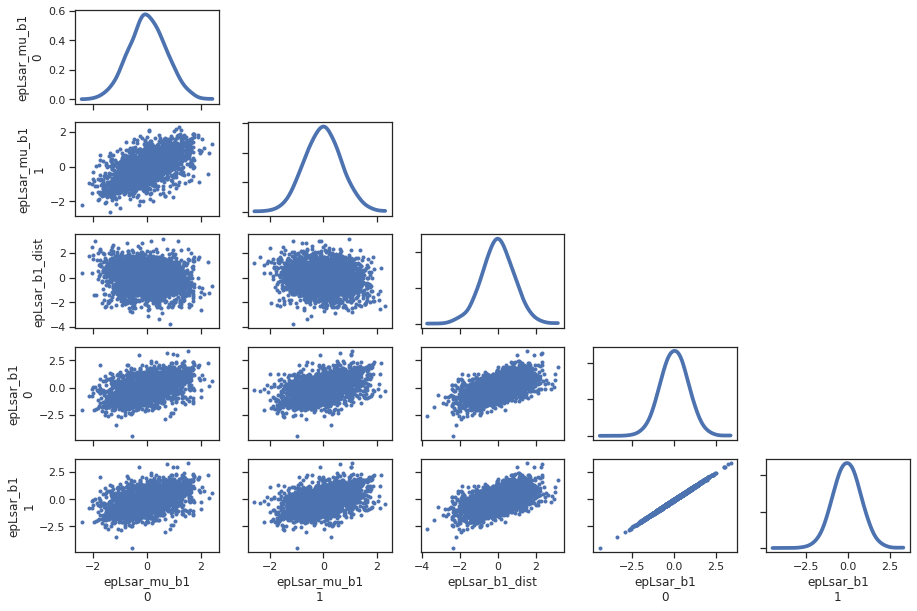

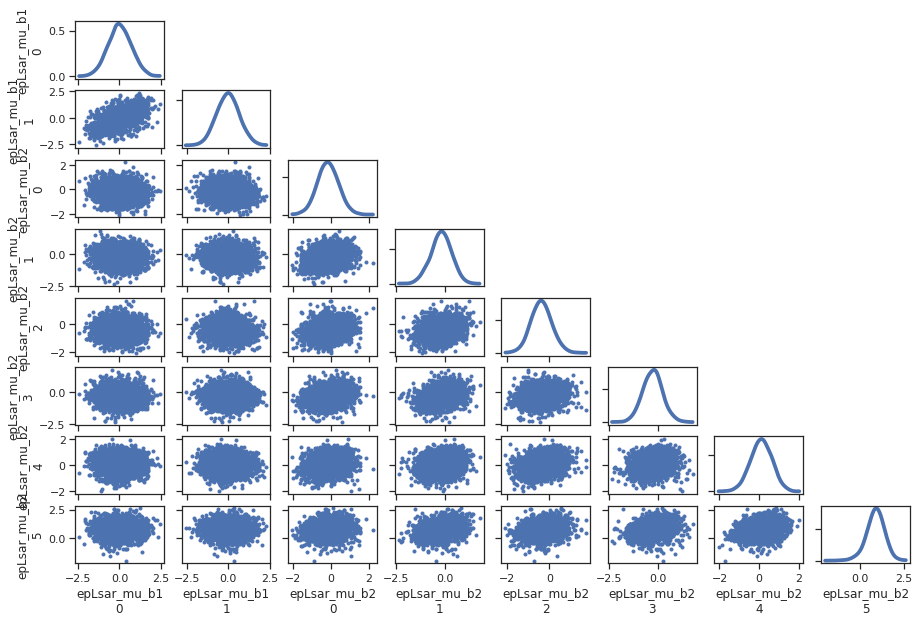

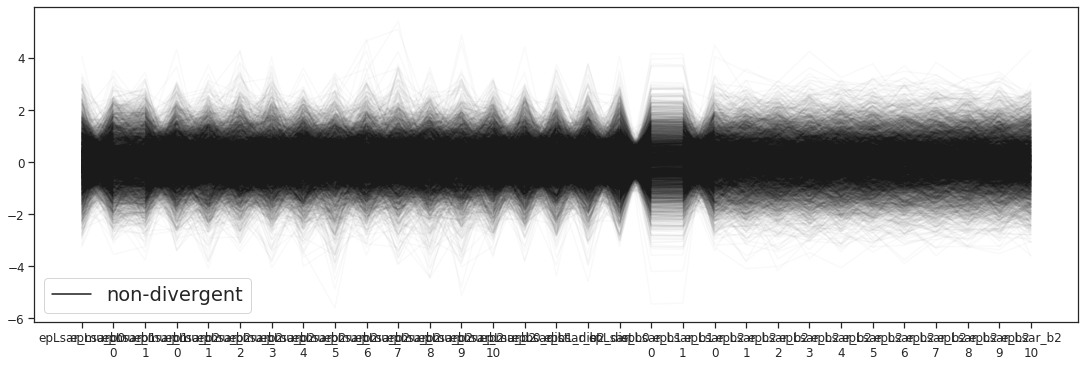

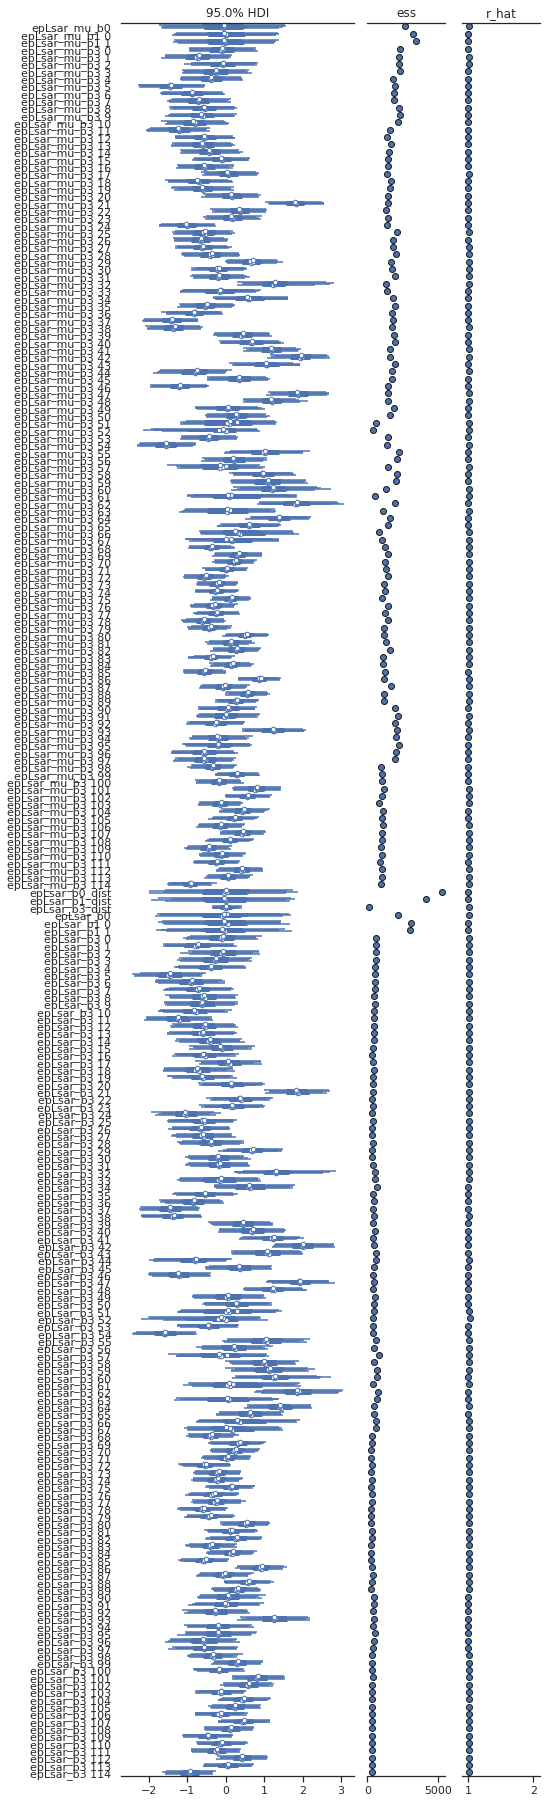

In [38]:
plotting_lib.plotDiagnostics(widthInch,heigthInch,dpi,writeOut,outPathPlots,\
                             trace_epLsar,dataTrace_epLsar,'epLsar',prefix)

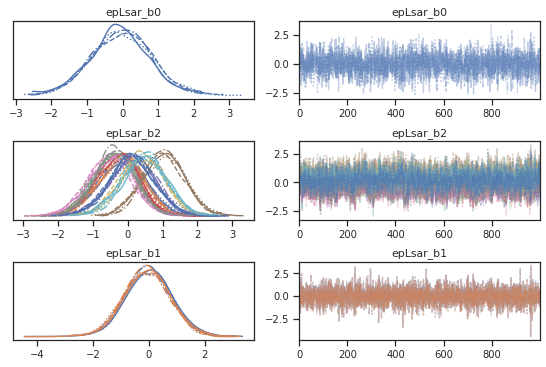

In [40]:
with epLsarModel as model:
    plotting_lib.plotTracesB(widthInch,heigthInch,dpi,writeOut,outPathPlots,\
                             trace_epLsar,'epLsar',prefix)

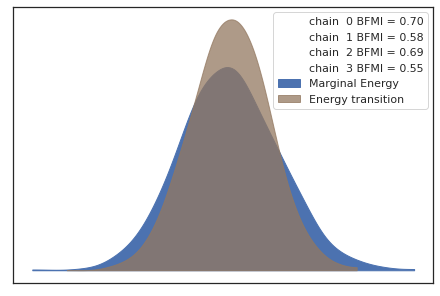

In [41]:
with epLsarModel as model:
    plotting_lib.pm.energyplot(trace_epLsar)

#### Posterior predictive distribution

In [42]:
with epLsarModel as model:
    posterior_pred_epLsar = pm.sample_posterior_predictive(trace_epLsar,samples=numPredSamples,random_seed=random_seed)

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


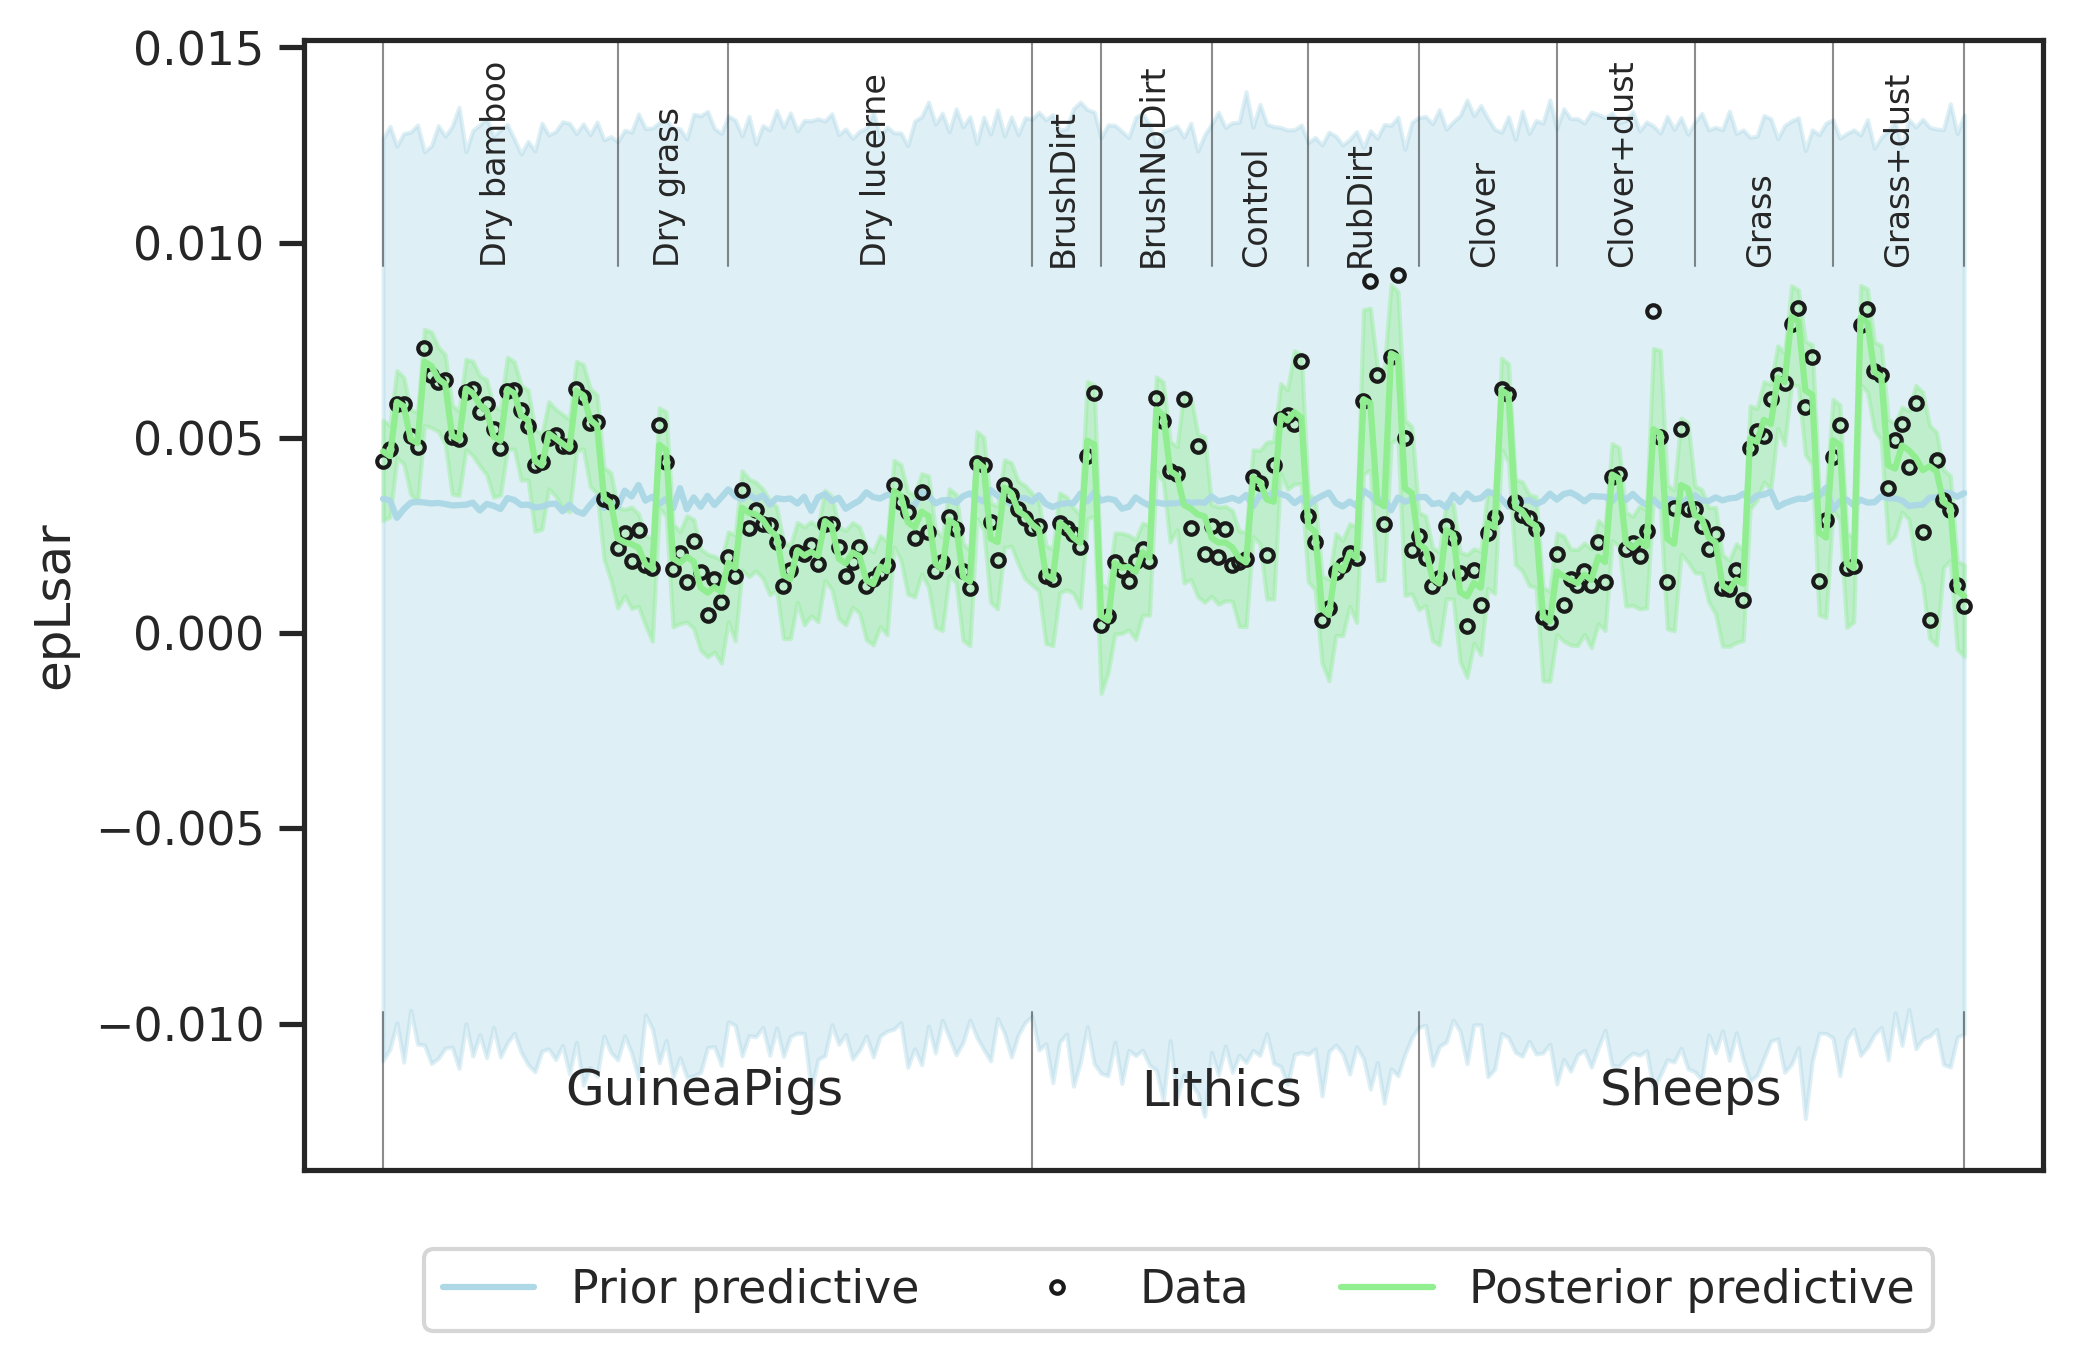

In [43]:
plotting_lib.plotPriorPosteriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,df,dictMeanStd,\
                                          prior_pred_epLsar,posterior_pred_epLsar,dataZ.epLsar_z.values,'epLsar',prefix)

#### Compare prior and posterior for model parameters

In [44]:
with epLsarModel as model:
    pm_data_epLsar = az.from_pymc3(trace=trace_epLsar,prior=prior_pred_epLsar,posterior_predictive=posterior_pred_epLsar)

arviz.data.io_pymc3 - WARNING - posterior predictive variable epLsar_y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


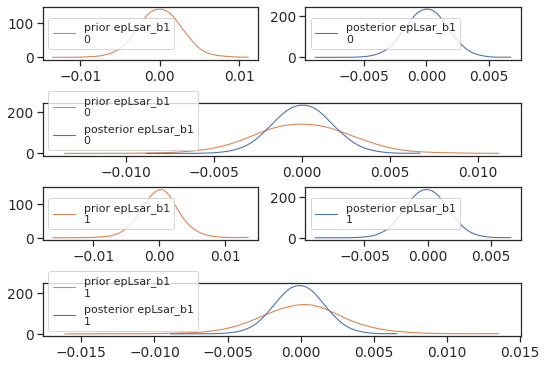

In [45]:
plotting_lib.plotPriorPosteriorB(widthInch,heigthInch,dpi,sizes,writeOut,outPathPlots,dictMeanStd,\
                                 pm_data_epLsar,'epLsar',prefix)

#### Posterior and contrasts

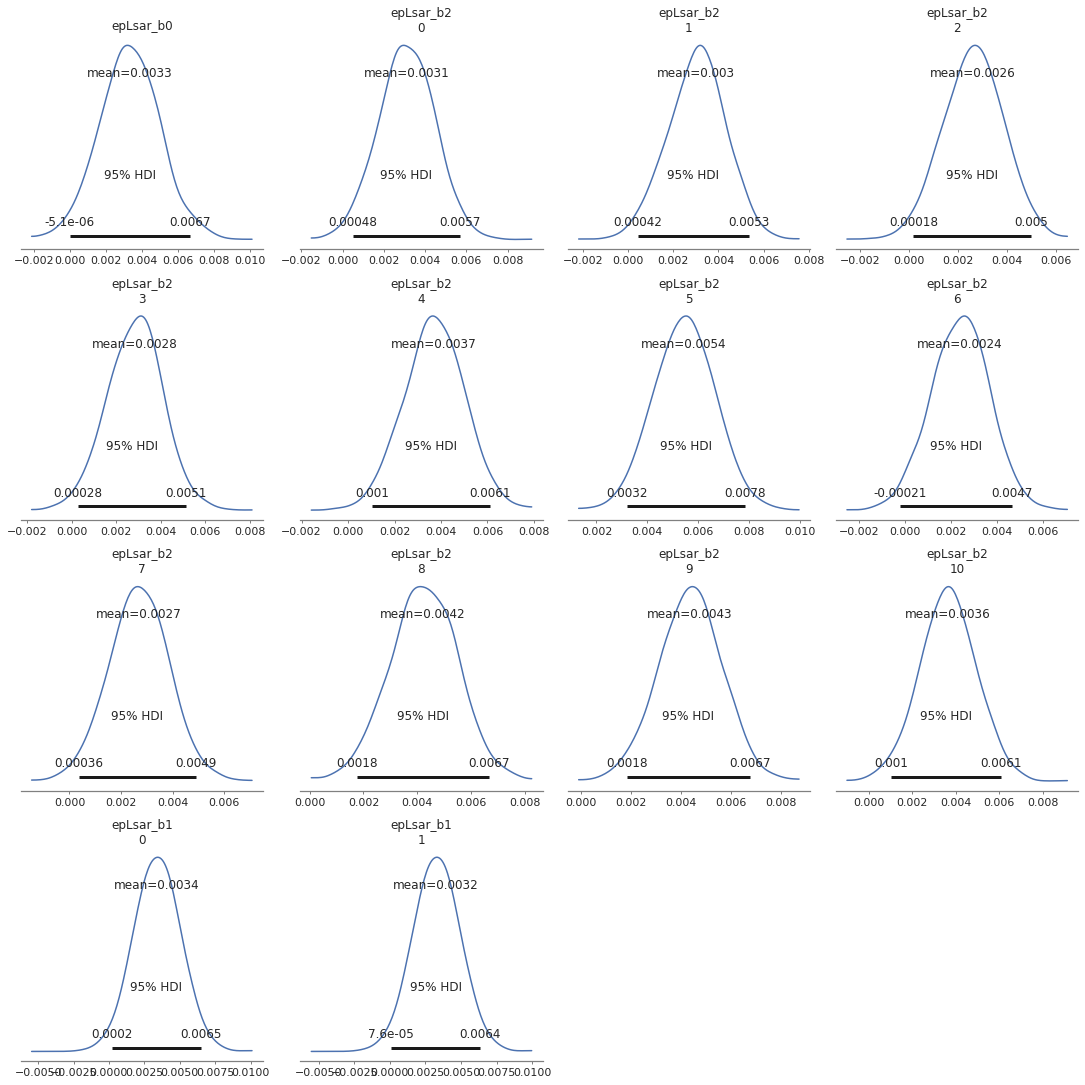

In [46]:
plotting_lib.plotPosterior(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                           pm_data_epLsar,'epLsar',prefix)

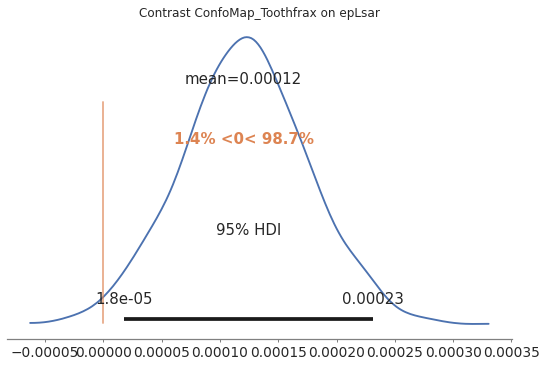

In [47]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                          x1contrast_dict,trace_epLsar,'epLsar',prefix)

### Rsquared<a name="r"></a>

In [48]:
with pm.Model() as model:
    RsquaredModel = ThreeFactorModel('Rsquared',x1,x2,x3,dataZ["Rsquared_z"].values)

#### Verify model settings

In [49]:
RsquaredModel.printParams(x1,x2,x3,dataZ["Rsquared_z"].values)

The number of levels of the x variables are (2, 11, 115)
The standard deviations used for the beta priors are (1.3690772711592387, 3.503507127699258, 7.588834883938683)


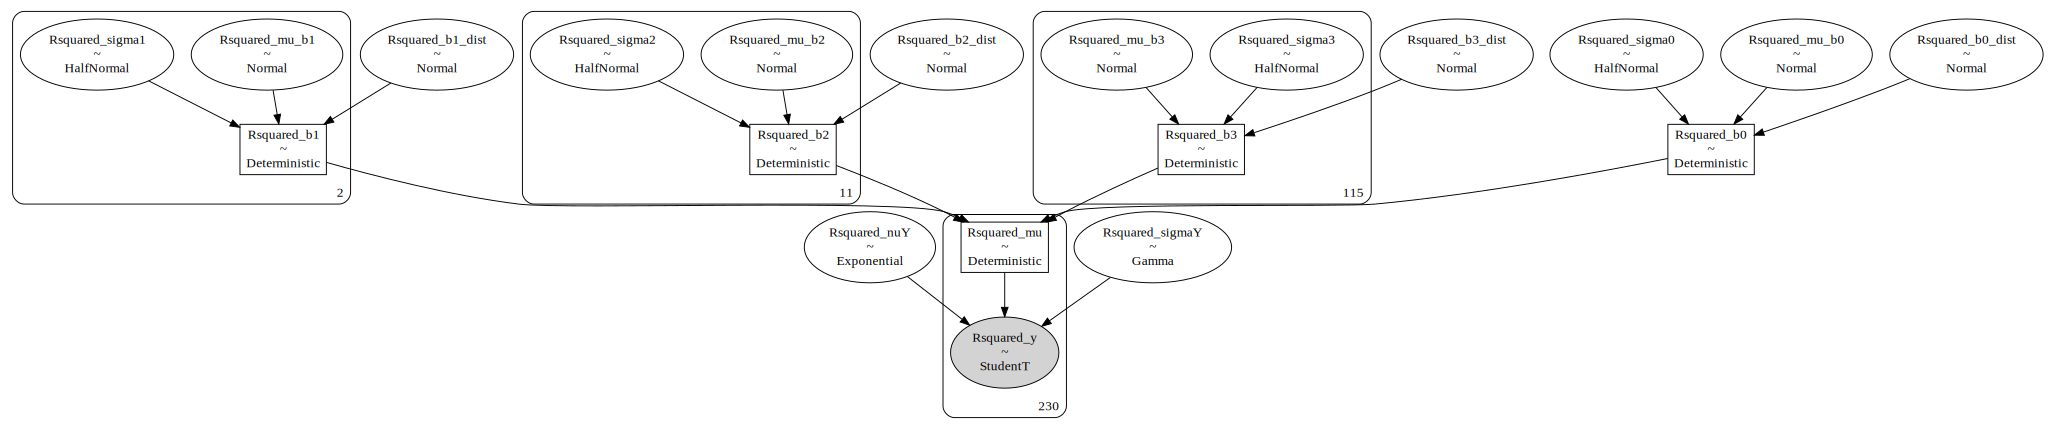

In [50]:
pm.model_to_graphviz(RsquaredModel)

#### Check prior choice

In [51]:
with RsquaredModel as model:
    prior_pred_Rsquared = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

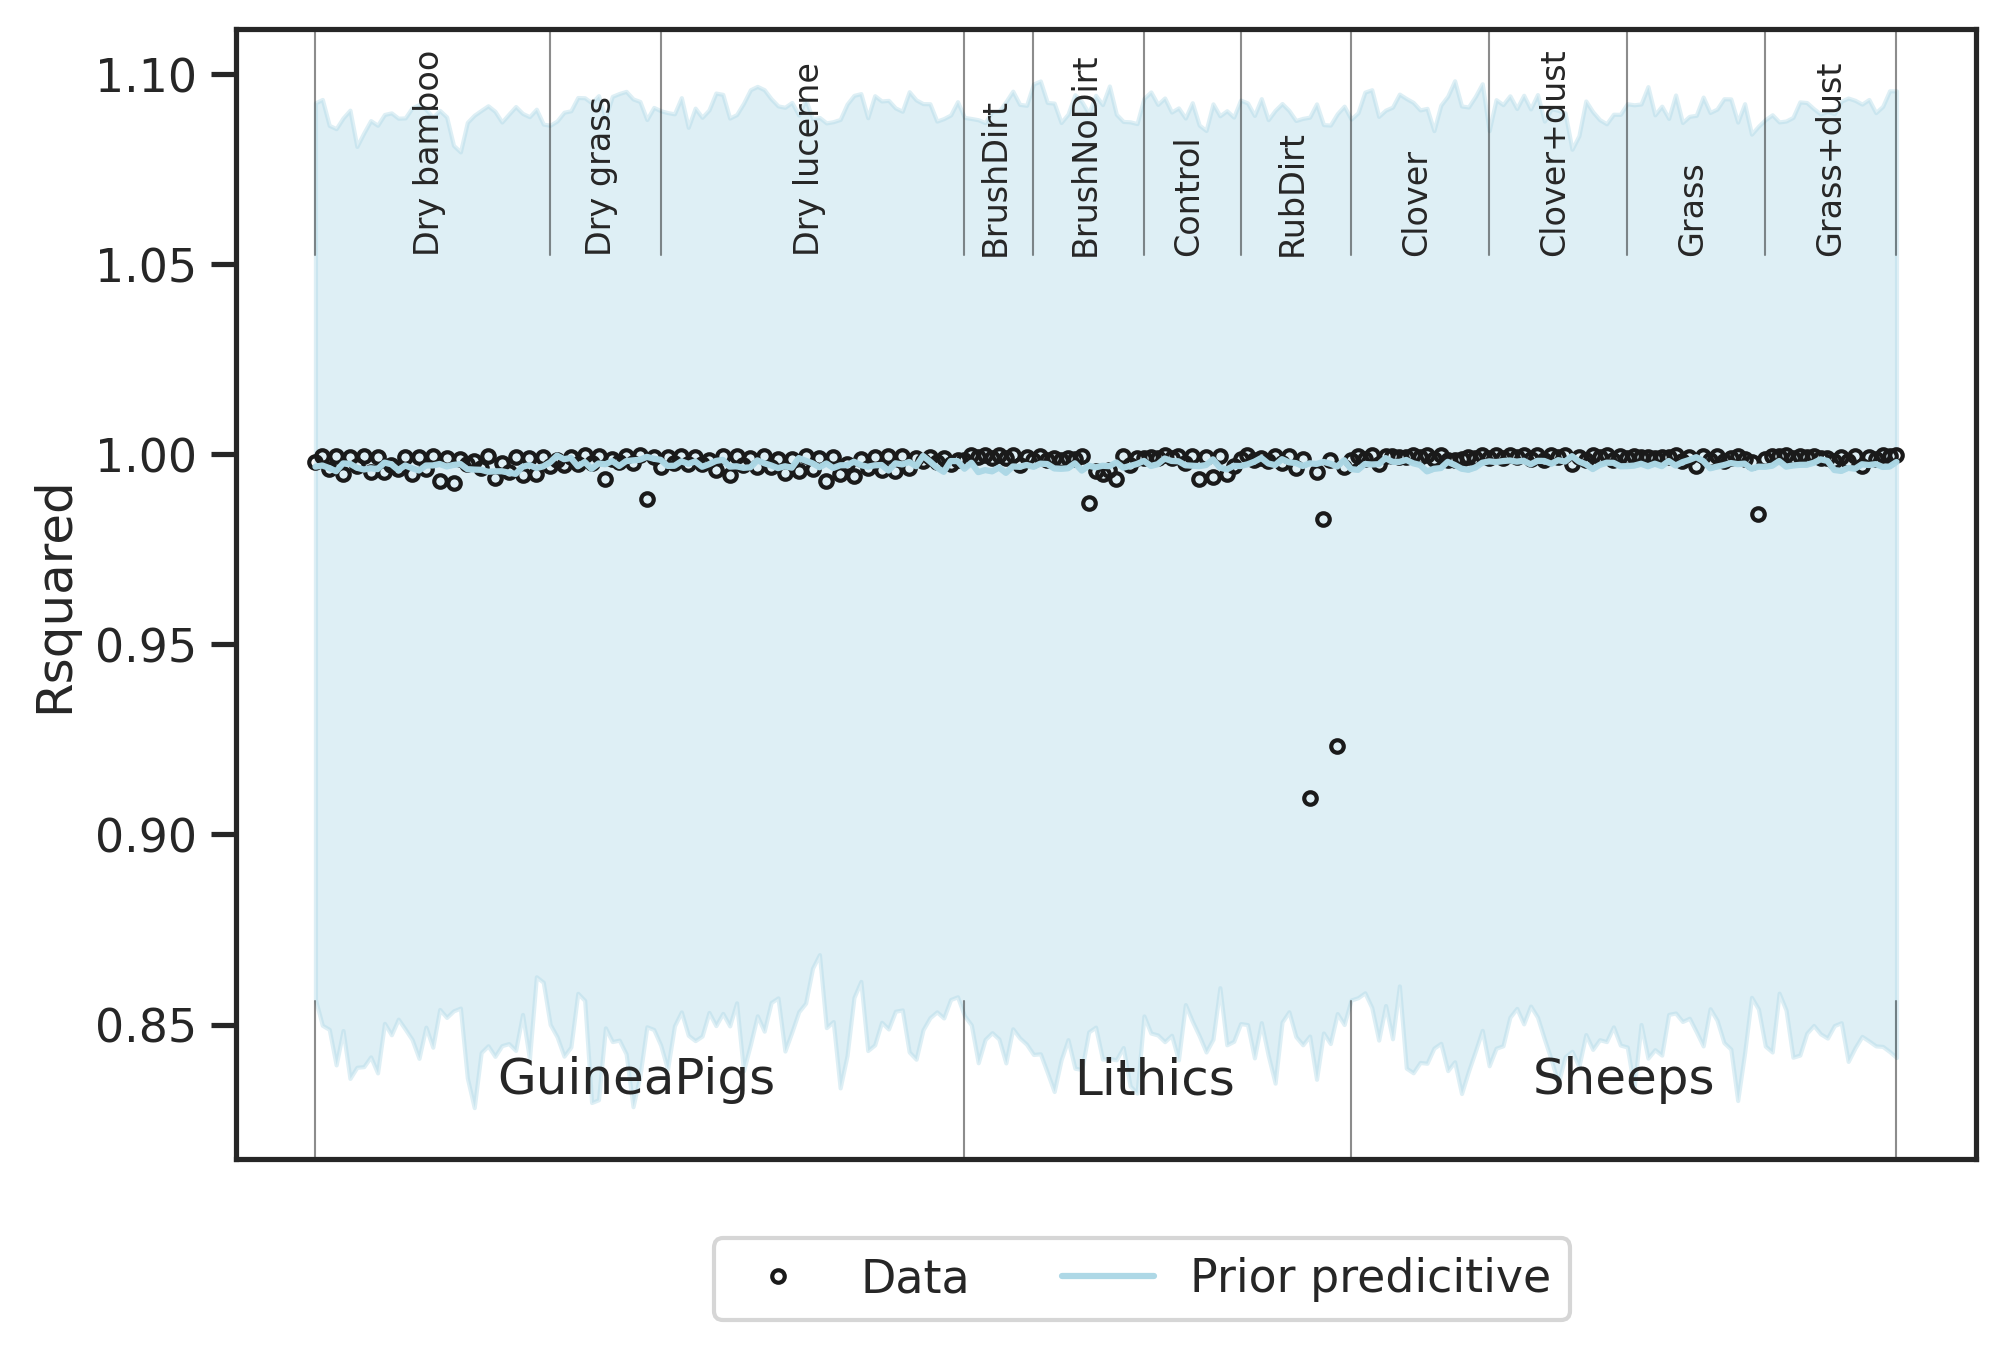

In [52]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,df,dictMeanStd,\
                                 prior_pred_Rsquared,dataZ["Rsquared_z"].values,'Rsquared',prefix)

#### Sampling

In [53]:
with RsquaredModel as model:
    trace_Rsquared = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=target_accept,random_seed=random_seed)
    #fit_Rsquared = pm.fit(random_seed=random_seed)
    #trace_Rsquared = fit_Rsquared.sample(draws=numSamples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rsquared_b3_dist, Rsquared_b2_dist, Rsquared_b1_dist, Rsquared_b0_dist, Rsquared_sigmaY, Rsquared_nuY, Rsquared_mu_b3, Rsquared_mu_b2, Rsquared_mu_b1, Rsquared_mu_b0, Rsquared_sigma3, Rsquared_sigma2, Rsquared_sigma1, Rsquared_sigma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1109 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [54]:
with RsquaredModel as model:
    if writeOut:
        with open(outPathData + '{}_model_{}.pkl'.format(prefix,'Rsquared'), 'wb') as buff:
            pickle.dump({'model': RsquaredModel, 'trace': trace_Rsquared}, buff)

#### Check sampling

In [55]:
with RsquaredModel as model:
    dataTrace_Rsquared = az.from_pymc3(trace=trace_Rsquared)

In [56]:
pm.summary(dataTrace_Rsquared,hdi_prob=0.95).round(2)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Rsquared_mu_b0     0.05  0.84     -1.54       1.74       0.02     0.01   
Rsquared_mu_b1[0] -0.06  0.73     -1.48       1.40       0.01     0.01   
Rsquared_mu_b1[1]  0.06  0.73     -1.34       1.51       0.01     0.01   
Rsquared_mu_b2[0]  0.09  0.54     -0.96       1.18       0.01     0.01   
Rsquared_mu_b2[1] -0.10  0.51     -1.10       0.88       0.01     0.01   
...                 ...   ...       ...        ...        ...      ...   
Rsquared_mu[225]   0.18  0.09     -0.00       0.35       0.00     0.00   
Rsquared_mu[226]   0.15  0.07     -0.00       0.28       0.00     0.00   
Rsquared_mu[227]   0.33  0.07      0.21       0.49       0.00     0.00   
Rsquared_mu[228]   0.20  0.09      0.04       0.38       0.00     0.00   
Rsquared_mu[229]   0.38  0.09      0.21       0.55       0.00     0.00   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Rsquared_mu_b0       3295.0  1812.0    3302.0    2786.0    1.0  
Rsquared_mu_b1[0]    2825.0  1979.0    2808.0    2487.0    1.0  
Rsquared_mu_b1[1]    2880.0  2004.0    2866.0    2494.0    1.0  
Rsquared_mu_b2[0]    1721.0  1721.0    1723.0    2236.0    1.0  
Rsquared_mu_b2[1]    1578.0  1578.0    1572.0    2142.0    1.0  
...                     ...     ...       ...       ...    ...  
Rsquared_mu[225]     4224.0  3376.0    4145.0    2678.0    1.0  
Rsquared_mu[226]     3966.0  3432.0    4157.0    2986.0    1.0  
Rsquared_mu[227]     3992.0  3992.0    4175.0    2921.0    1.0  
Rsquared_mu[228]     4466.0  3224.0    4199.0    3003.0    1.0  
Rsquared_mu[229]     4374.0  3913.0    4141.0    2890.0    1.0  

[623 rows x 11 columns]

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 

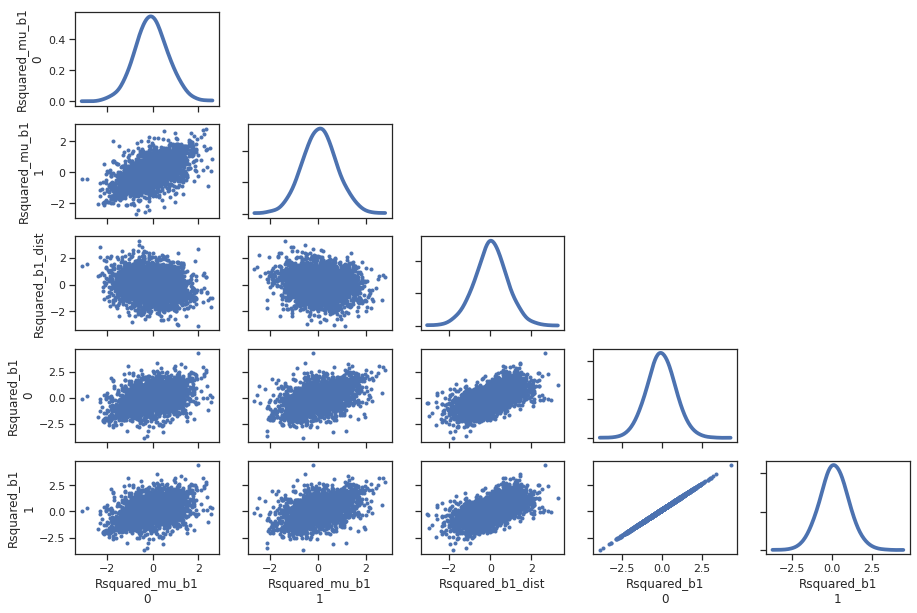

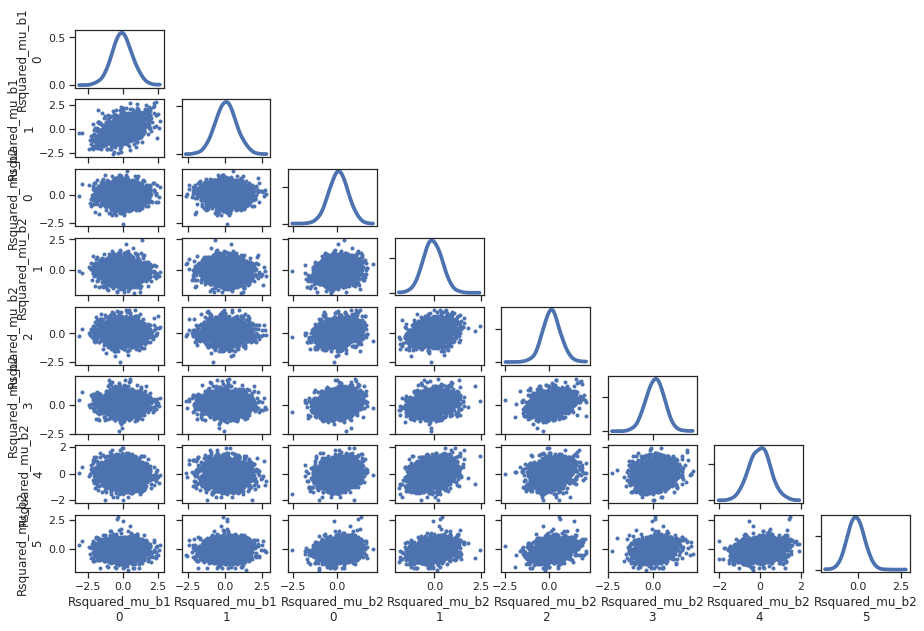

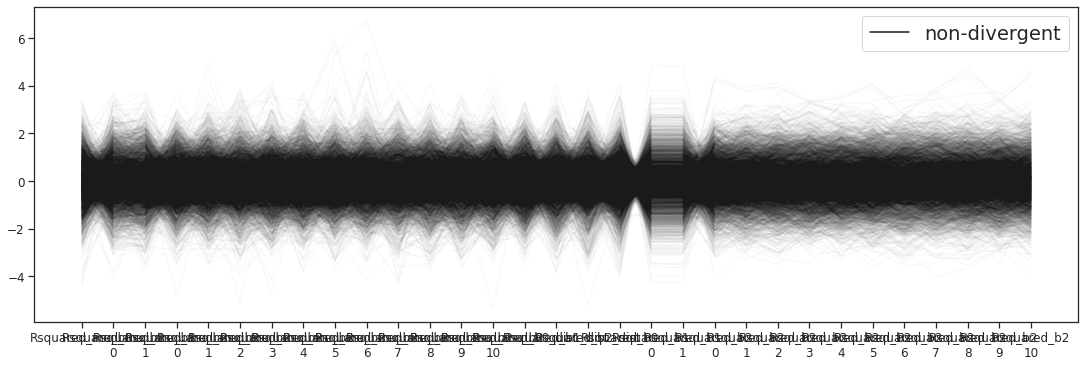

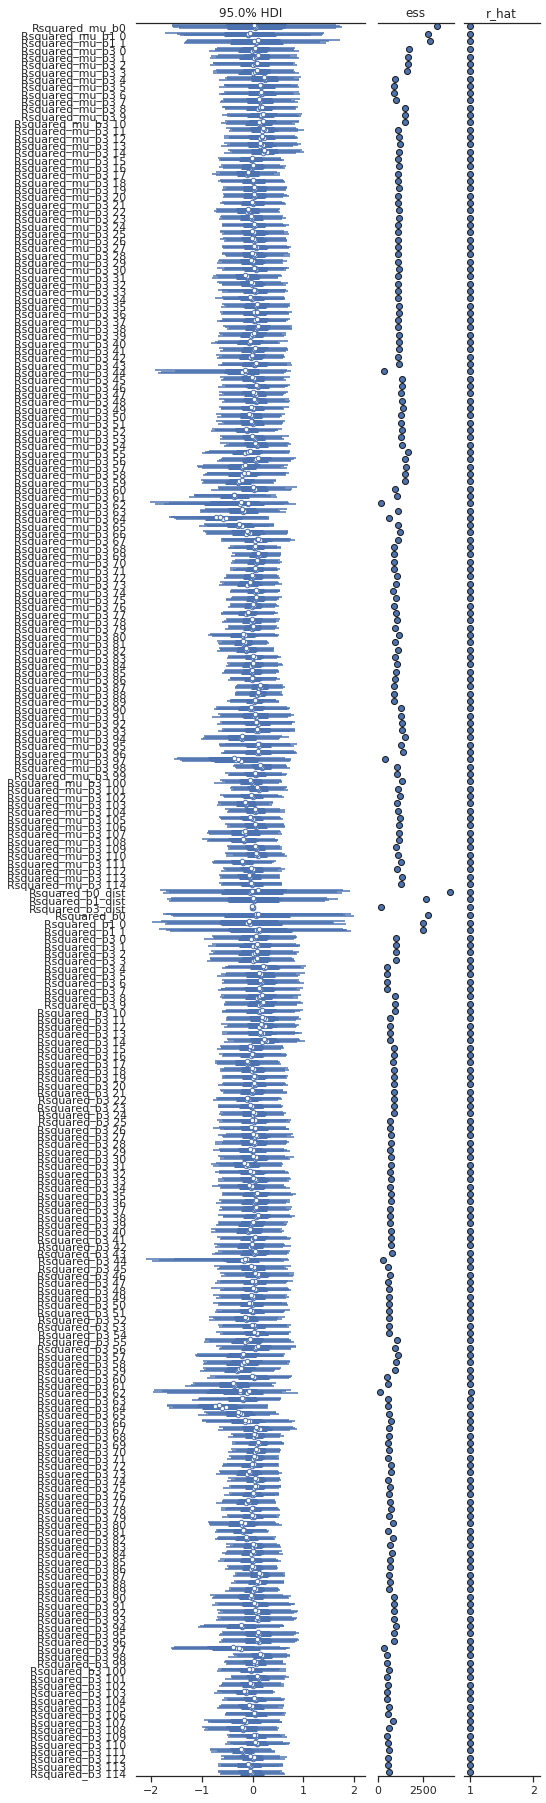

In [57]:
plotting_lib.plotDiagnostics(widthInch,heigthInch,dpi,writeOut,outPathPlots,\
                             dataTrace_Rsquared,trace_Rsquared,'Rsquared',prefix)

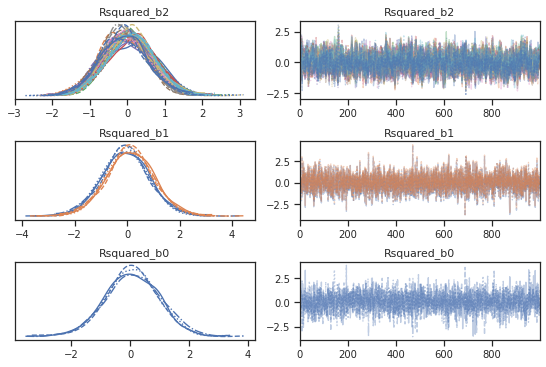

In [59]:
with RsquaredModel as model:
    plotting_lib.plotTracesB(widthInch,heigthInch,dpi,writeOut,outPathPlots,trace_Rsquared,'Rsquared',prefix)

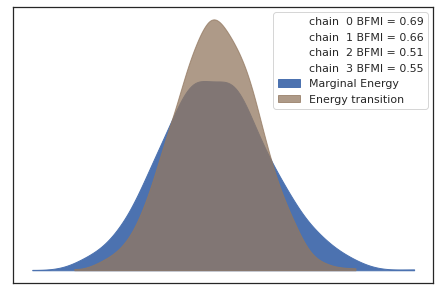

In [60]:
with RsquaredModel as model:
    plotting_lib.pm.energyplot(trace_Rsquared)

#### Posterior predictive distribution

In [61]:
with RsquaredModel as model:
    posterior_pred_Rsquared = pm.sample_posterior_predictive(trace_Rsquared,samples=numPredSamples,random_seed=random_seed)

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


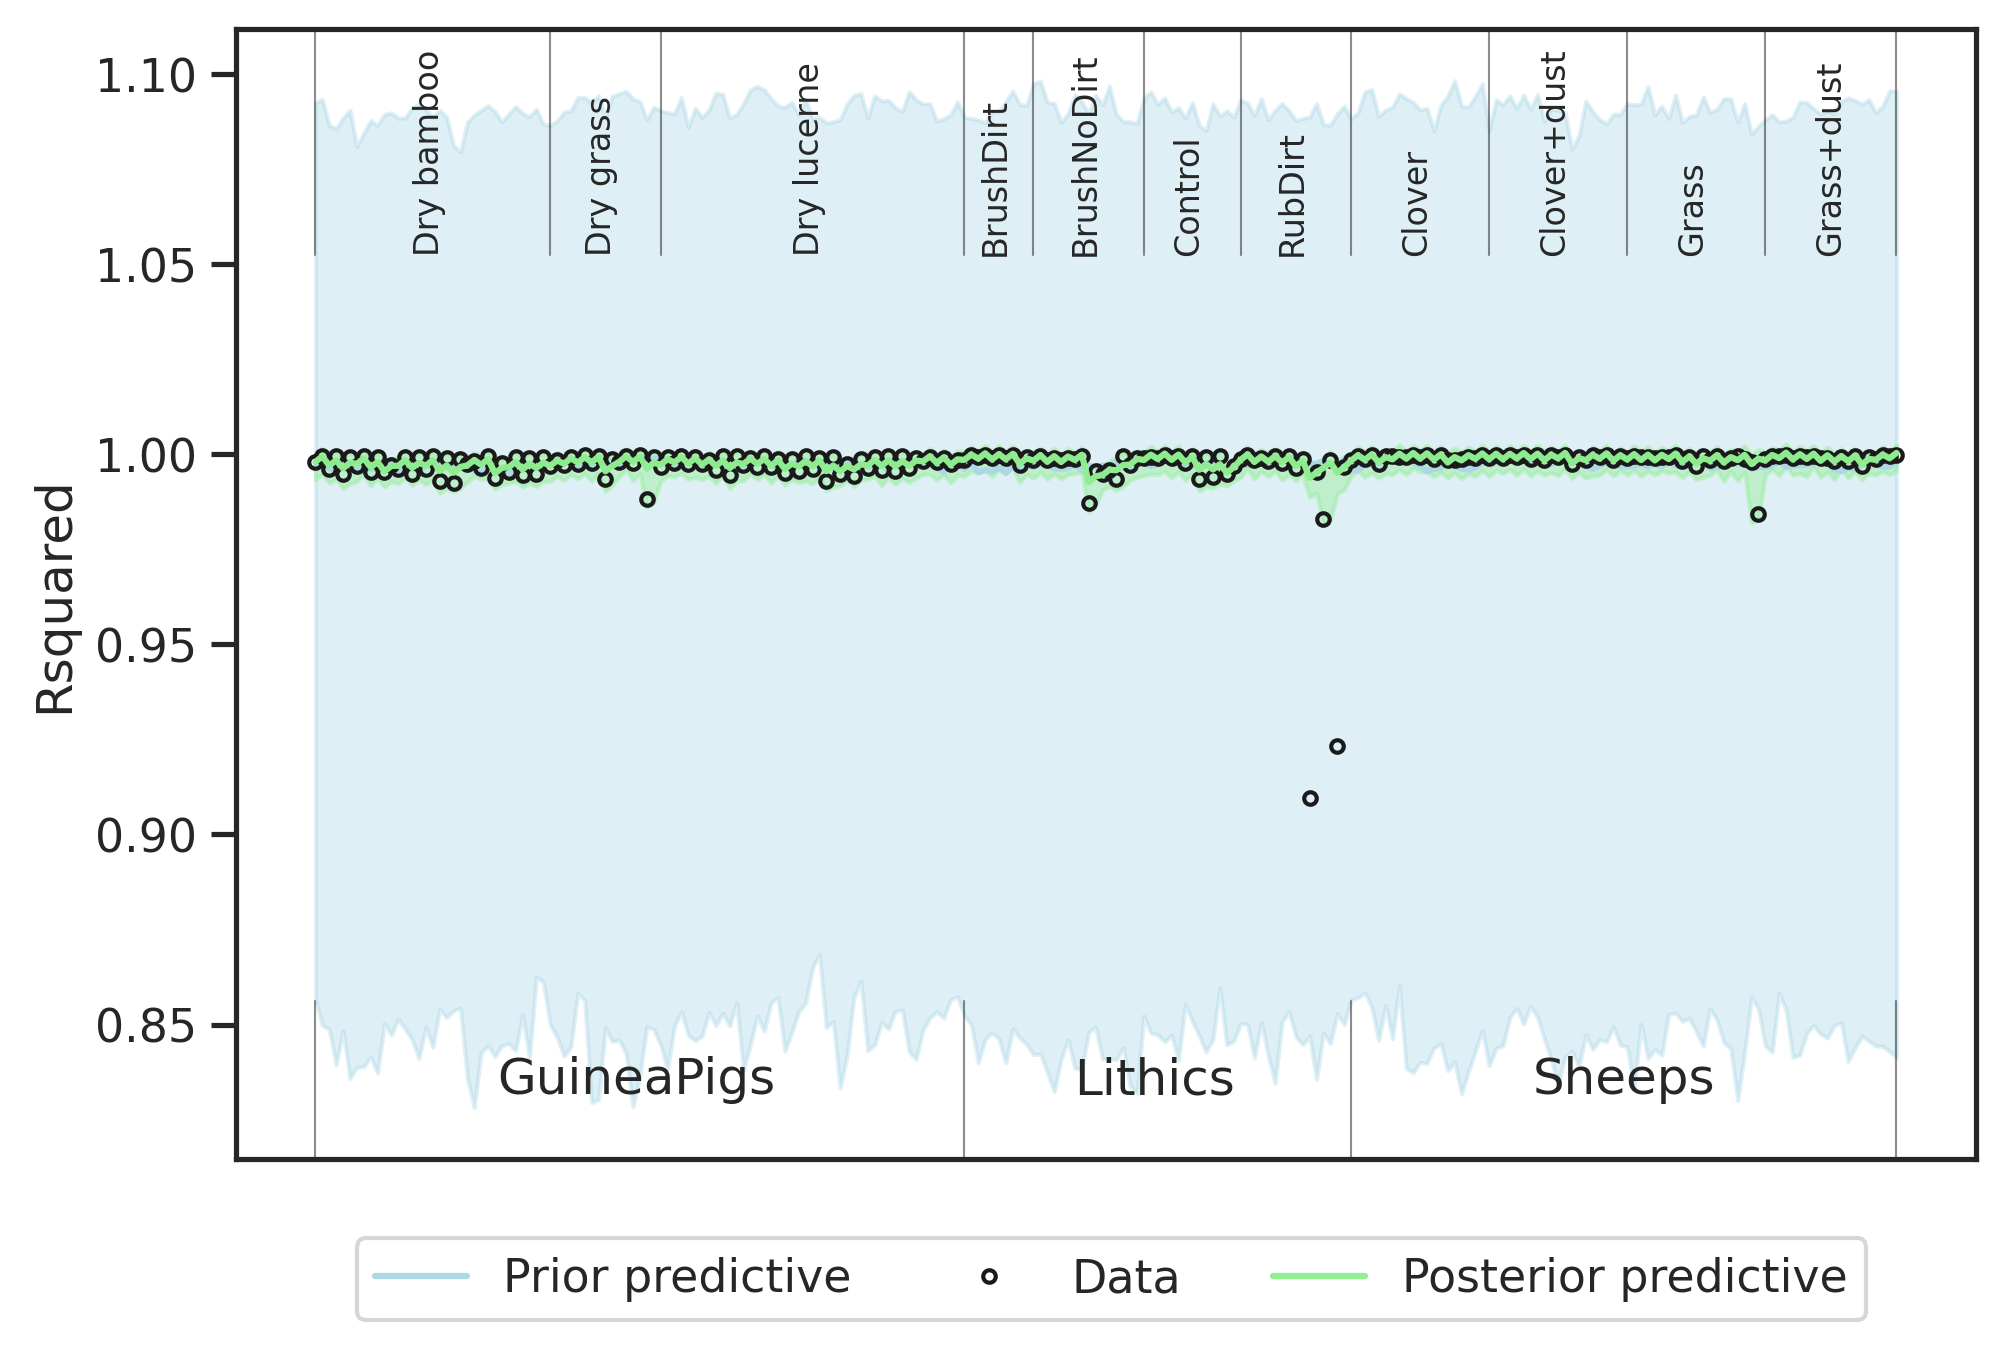

In [63]:
plotting_lib.plotPriorPosteriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,df,dictMeanStd,\
                                          prior_pred_Rsquared,posterior_pred_Rsquared,dataZ["Rsquared_z"].values,'Rsquared',prefix)

#### Compare prior and posterior for model parameters

In [64]:
with RsquaredModel as model:
    pm_data_Rsquared = az.from_pymc3(trace=trace_Rsquared,prior=prior_pred_Rsquared,posterior_predictive=posterior_pred_Rsquared)

arviz.data.io_pymc3 - WARNING - posterior predictive variable Rsquared_y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


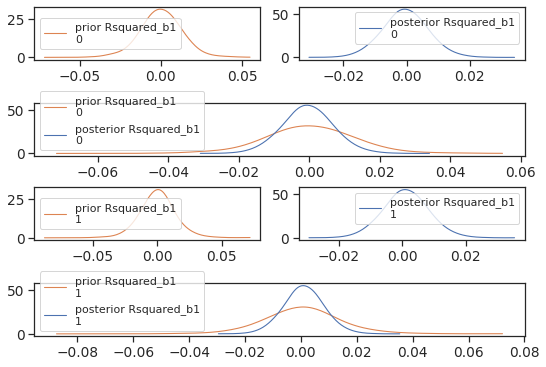

In [65]:
plotting_lib.plotPriorPosteriorB(widthInch,heigthInch,dpi,sizes,writeOut,\
                                 outPathPlots,dictMeanStd,pm_data_Rsquared,'Rsquared',prefix)

#### Posterior and contrasts

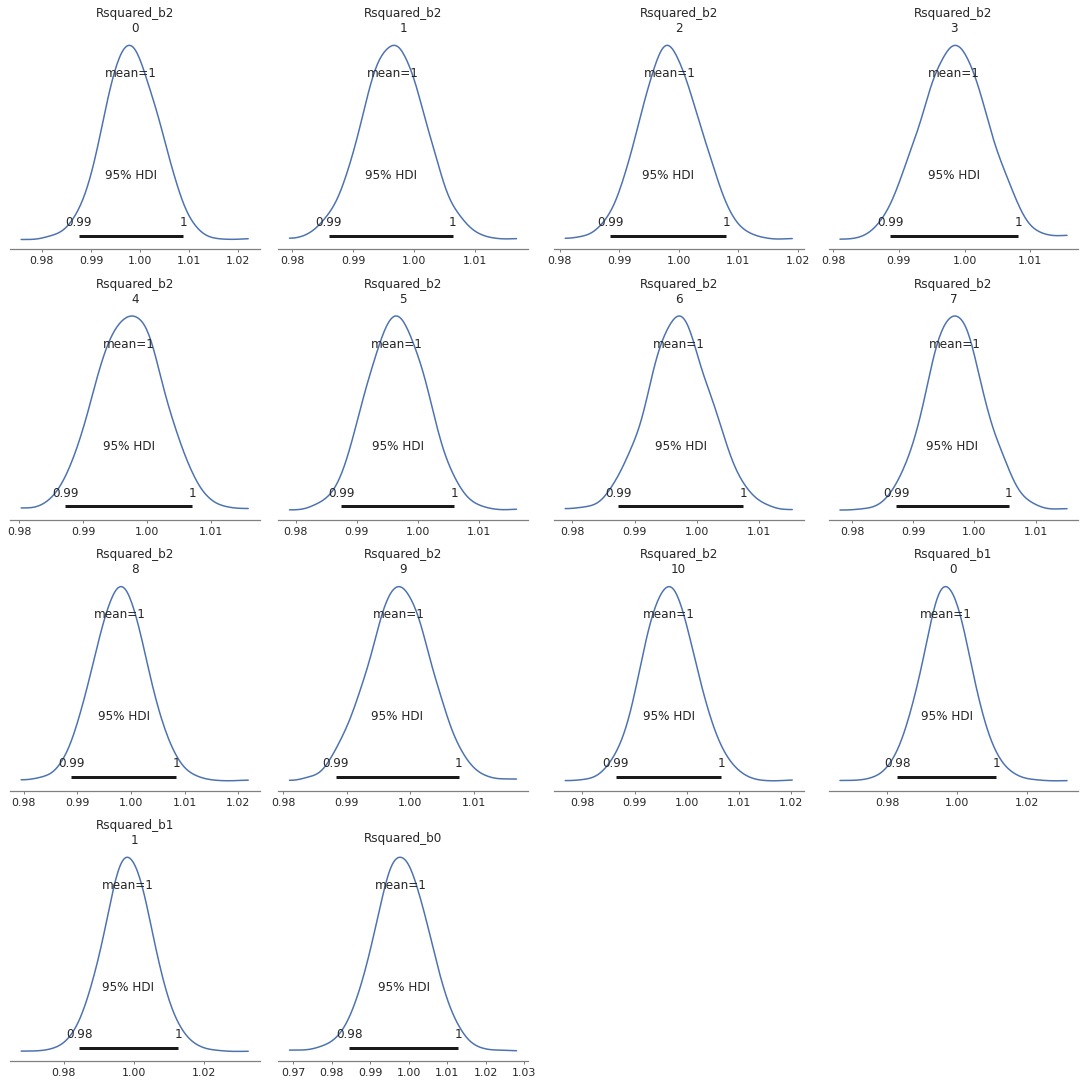

In [66]:
plotting_lib.plotPosterior(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,pm_data_Rsquared,'Rsquared',prefix)

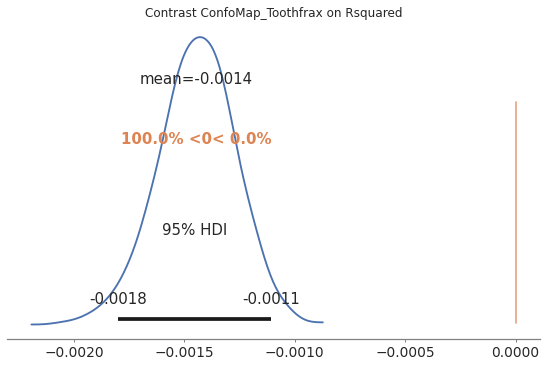

In [67]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                          x1contrast_dict,trace_Rsquared,'Rsquared',prefix)

### Asfc  <a name="Asfc"></a>

In [68]:
with pm.Model() as model:
    AsfcModel = ThreeFactorModel('Asfc',x1,x2,x3,dataZ["Asfc_z"].values)

#### Verify model settings

In [69]:
AsfcModel.printParams(x1,x2,x3,dataZ["Asfc_z"].values)

The number of levels of the x variables are (2, 11, 115)
The standard deviations used for the beta priors are (1.0817297140638054, 1.6678950572969222, 0.44957387459221787)


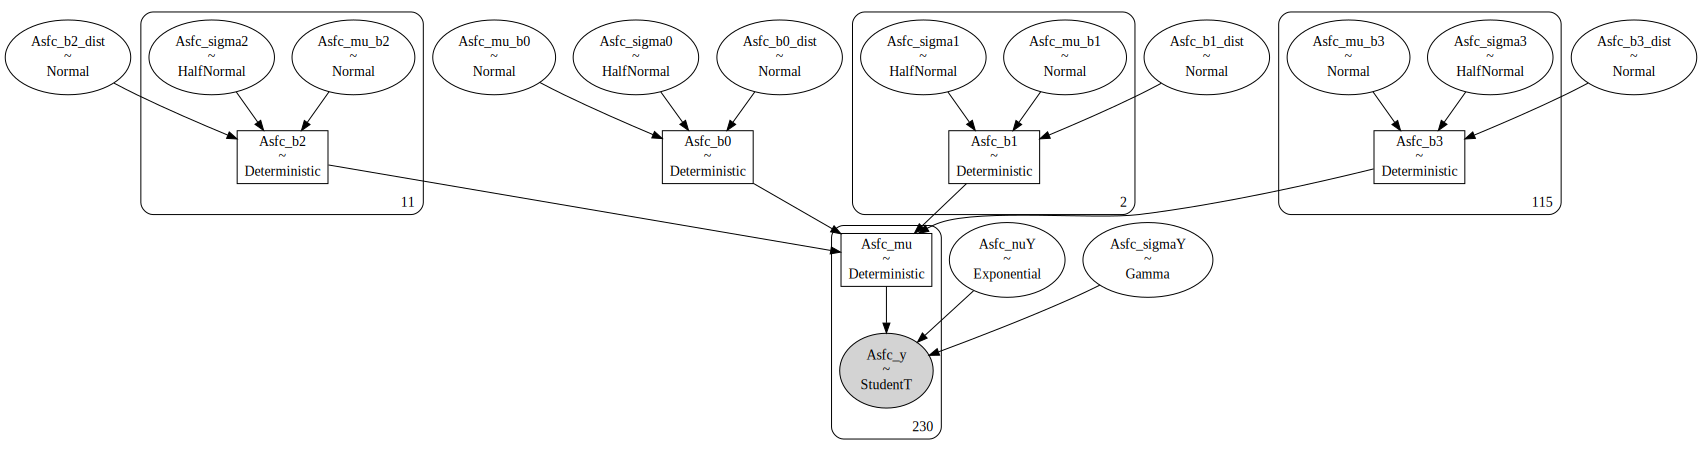

In [70]:
pm.model_to_graphviz(AsfcModel)

#### Check prior choice

In [71]:
with AsfcModel as model:
    prior_pred_Asfc = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

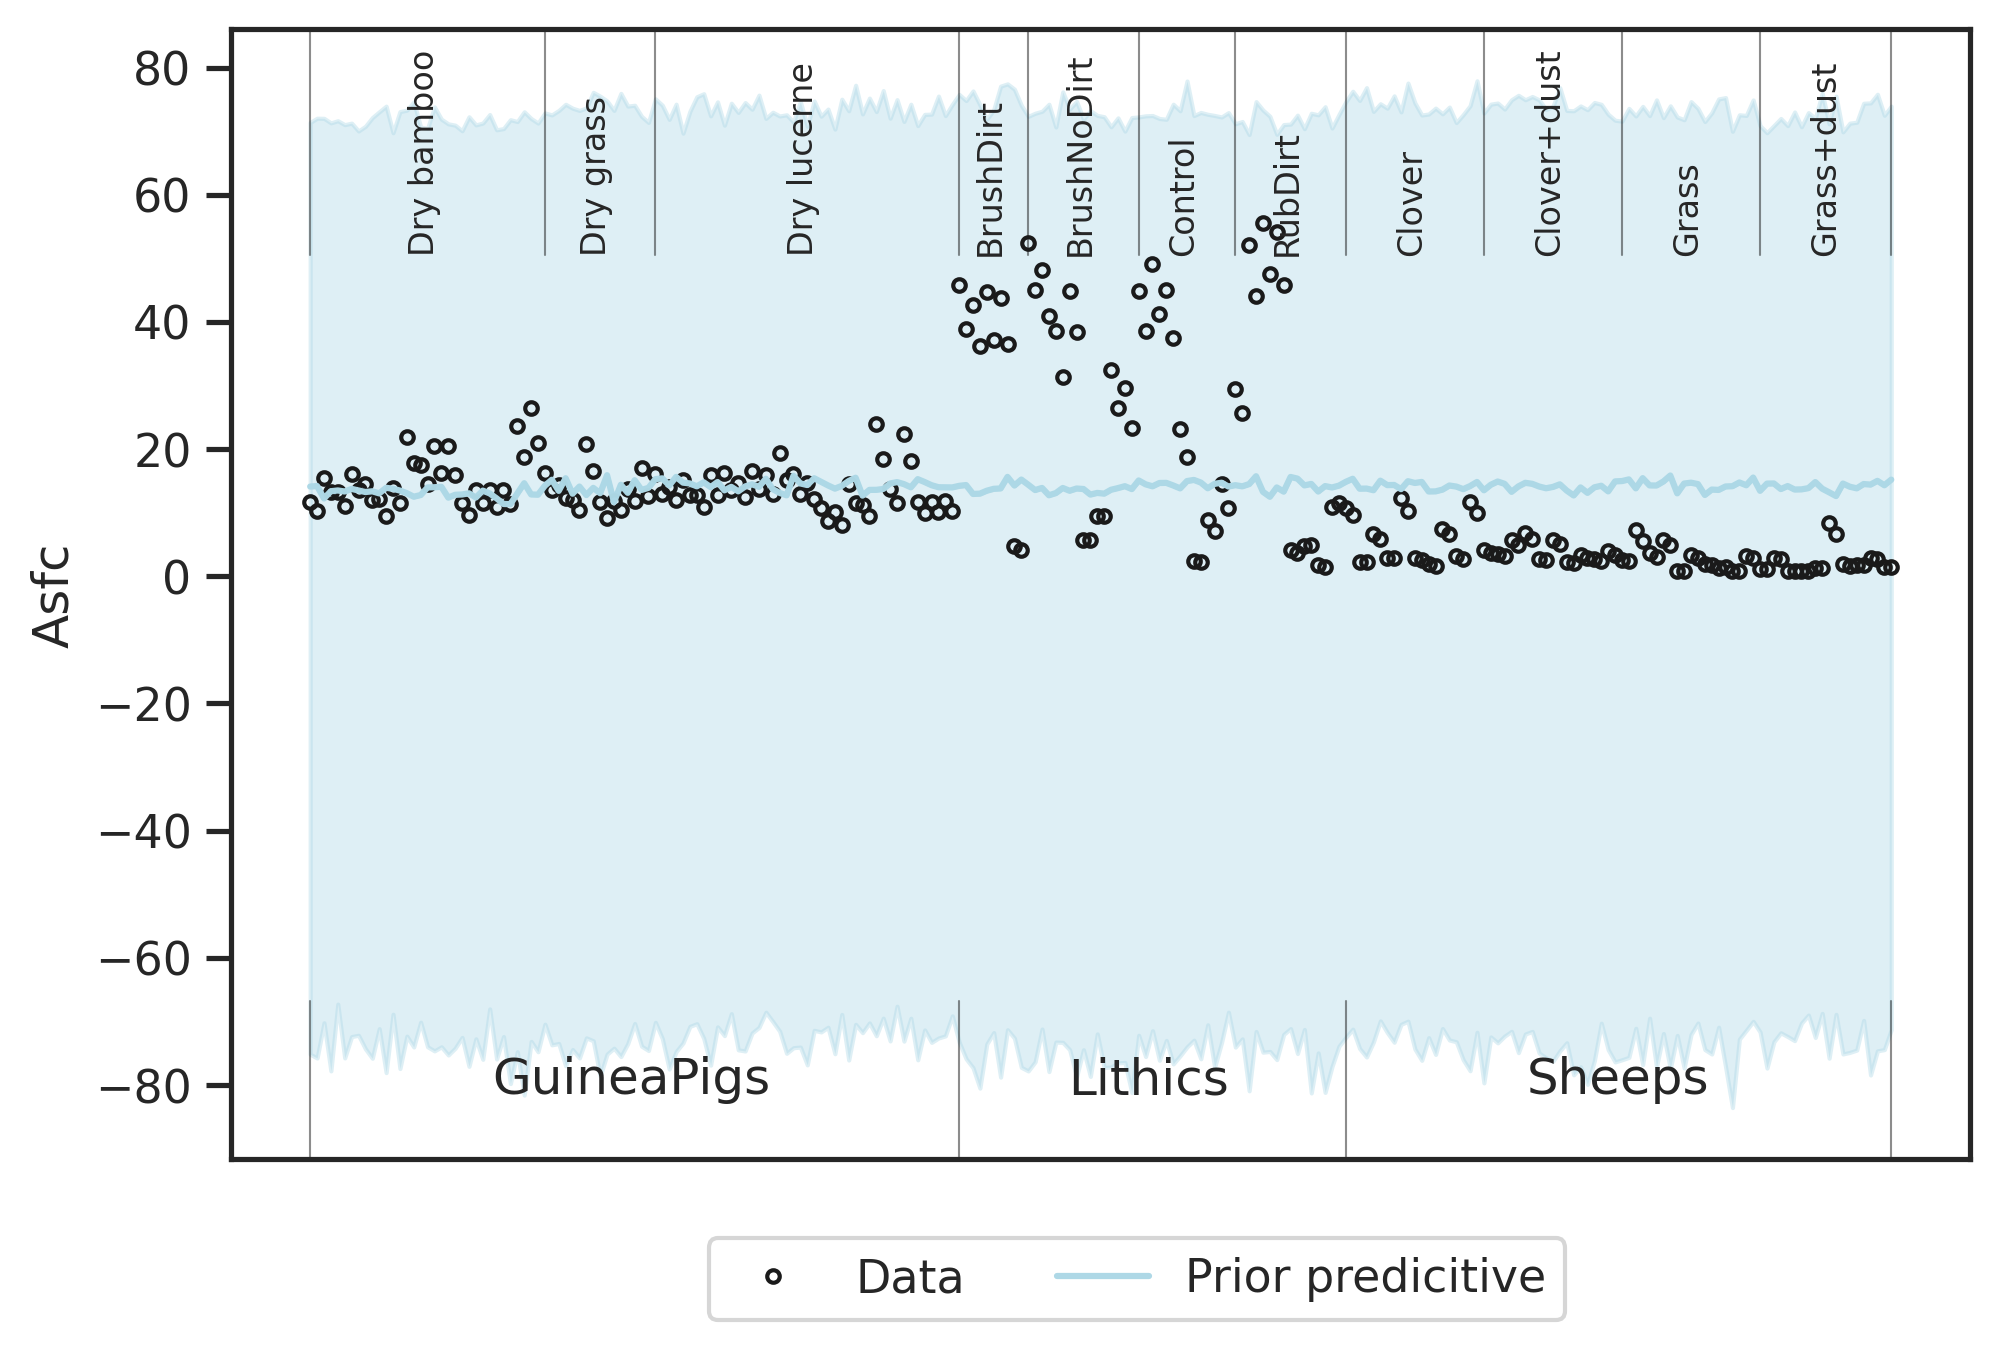

In [72]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,writeOut,\
                                 outPathPlots,df,dictMeanStd,prior_pred_Asfc,dataZ["Asfc_z"].values,'Asfc',prefix)

Prior choice is as intended: Broad over the data range.

#### Sampling

In [73]:
with AsfcModel as model:
    trace_Asfc = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=target_accept,random_seed=random_seed)
    #fit_Asfc = pm.fit(random_seed=random_seed)
    #trace_Asfc = fit_Asfc.sample(draws=numSamples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Asfc_b3_dist, Asfc_b2_dist, Asfc_b1_dist, Asfc_b0_dist, Asfc_sigmaY, Asfc_nuY, Asfc_mu_b3, Asfc_mu_b2, Asfc_mu_b1, Asfc_mu_b0, Asfc_sigma3, Asfc_sigma2, Asfc_sigma1, Asfc_sigma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 634 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [74]:
with AsfcModel as model:
    if writeOut:
        with open(outPathData + '{}_model_{}.pkl'.format(prefix,'Asfc'), 'wb') as buff:
            pickle.dump({'model': AsfcModel, 'trace': trace_Asfc}, buff)

#### Check sampling

In [75]:
with AsfcModel as model:
    dataTrace_Asfc = az.from_pymc3(trace=trace_Asfc)

In [76]:
pm.summary(dataTrace_Asfc,hdi_prob=0.95).round(2)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
Asfc_mu_b0     0.05  0.82     -1.65       1.56       0.02     0.01    2550.0   
Asfc_mu_b1[0]  0.09  0.70     -1.29       1.45       0.01     0.01    3058.0   
Asfc_mu_b1[1] -0.08  0.69     -1.43       1.29       0.01     0.01    2890.0   
Asfc_mu_b2[0]  1.05  0.59     -0.20       2.08       0.02     0.01    1569.0   
Asfc_mu_b2[1]  0.91  0.54     -0.13       1.92       0.01     0.01    1496.0   
...             ...   ...       ...        ...        ...      ...       ...   
Asfc_mu[225]  -1.01  0.09     -1.20      -0.84       0.00     0.00    3922.0   
Asfc_mu[226]  -0.76  0.09     -0.93      -0.58       0.00     0.00    3856.0   
Asfc_mu[227]  -0.94  0.09     -1.11      -0.76       0.00     0.00    3861.0   
Asfc_mu[228]  -0.86  0.09     -1.04      -0.68       0.00     0.00    3964.0   
Asfc_mu[229]  -1.04  0.09     -1.23      -0.87       0.00     0.00    4010.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
Asfc_mu_b0     2402.0    2544.0    2779.0    1.0  
Asfc_mu_b1[0]  2386.0    3058.0    3085.0    1.0  
Asfc_mu_b1[1]  2530.0    2891.0    3163.0    1.0  
Asfc_mu_b2[0]  1569.0    1580.0    2218.0    1.0  
Asfc_mu_b2[1]  1496.0    1506.0    2389.0    1.0  
...               ...       ...       ...    ...  
Asfc_mu[225]   3920.0    3924.0    2855.0    1.0  
Asfc_mu[226]   3848.0    3855.0    2852.0    1.0  
Asfc_mu[227]   3855.0    3866.0    2900.0    1.0  
Asfc_mu[228]   3963.0    3964.0    3000.0    1.0  
Asfc_mu[229]   4010.0    4024.0    2897.0    1.0  

[623 rows x 11 columns]

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


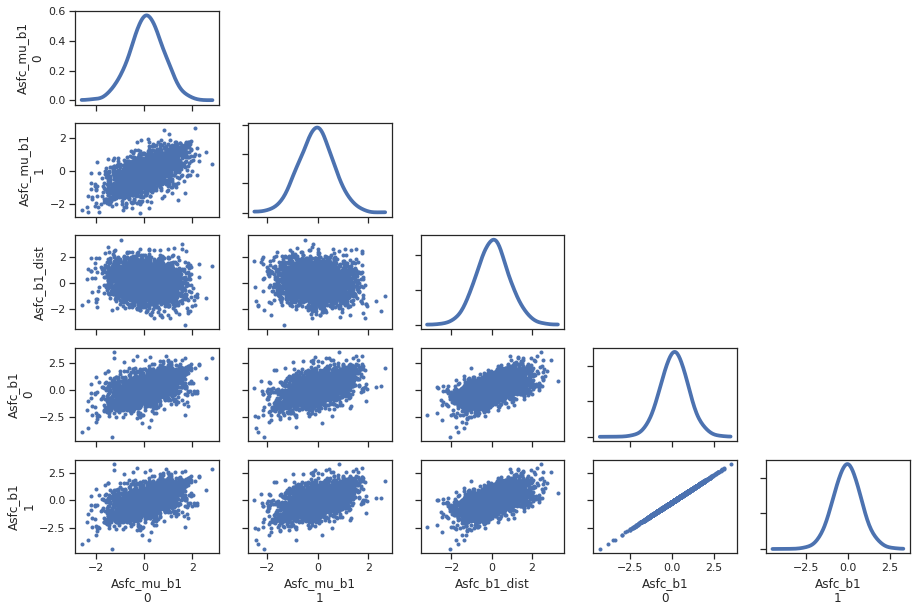

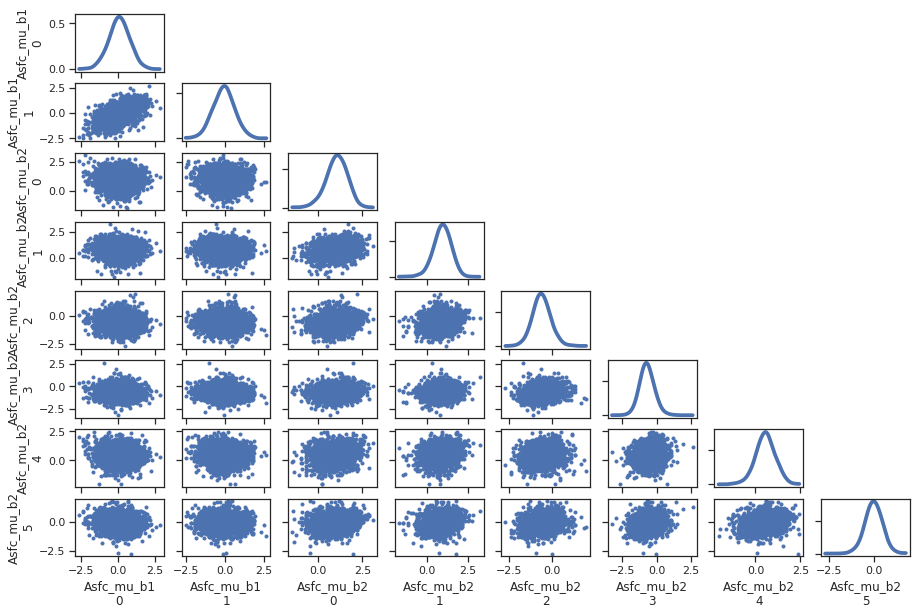

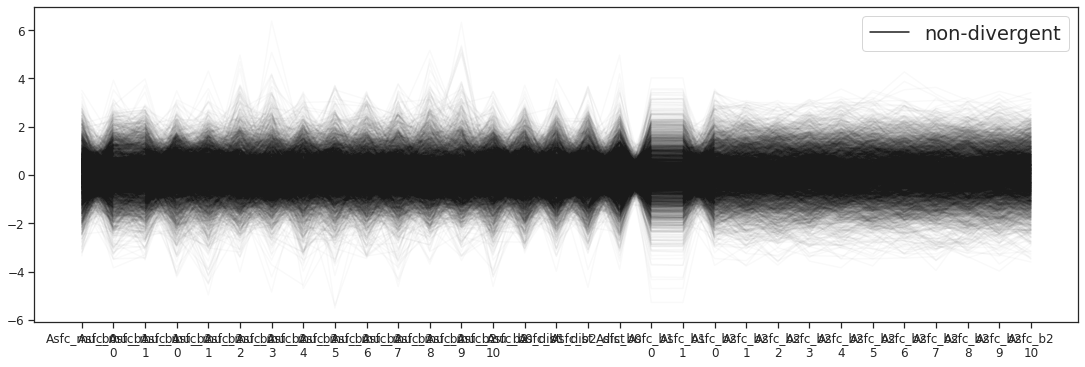

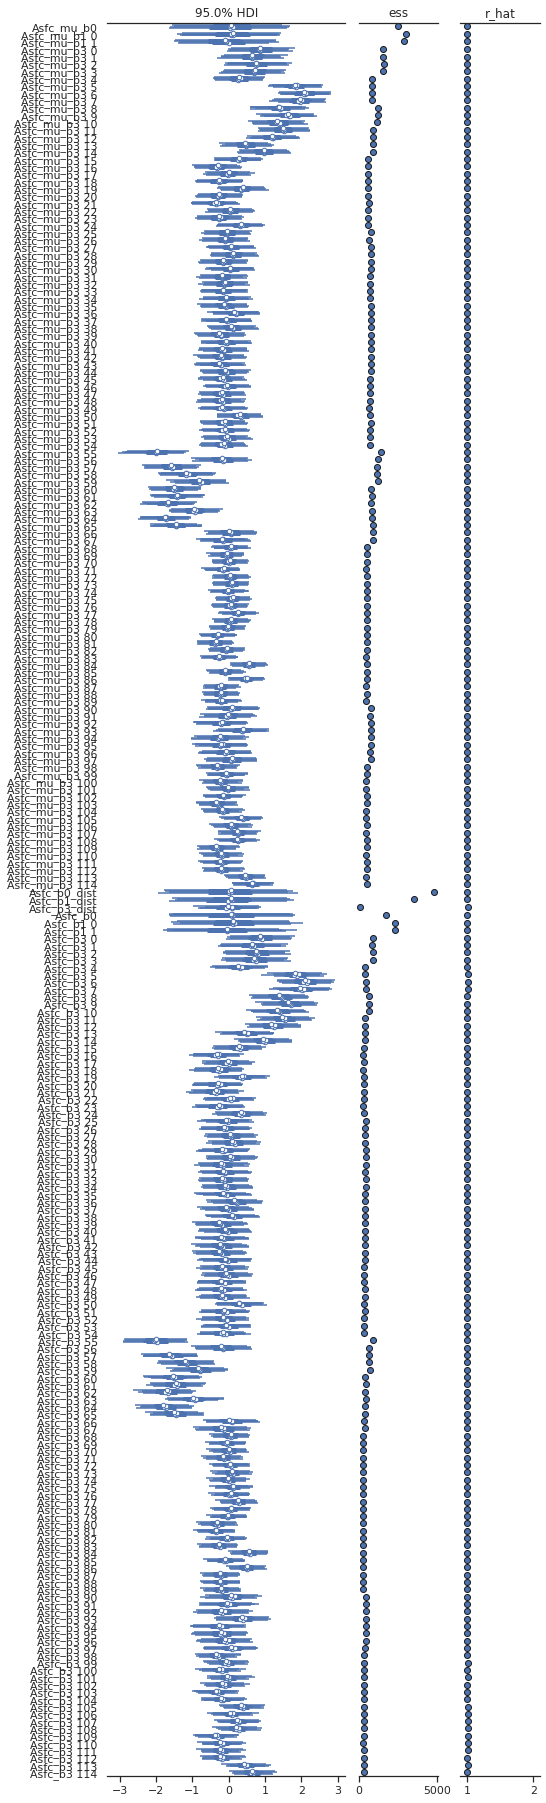

In [77]:
plotting_lib.plotDiagnostics(widthInch,heigthInch,dpi,writeOut,outPathPlots,trace_Asfc,dataTrace_Asfc,'Asfc',prefix)

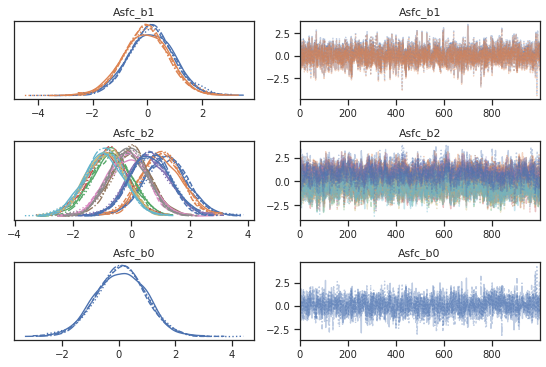

In [78]:
with AsfcModel as model:
    plotting_lib.plotTracesB(widthInch,heigthInch,dpi,writeOut,outPathPlots,trace_Asfc,'Asfc',prefix)

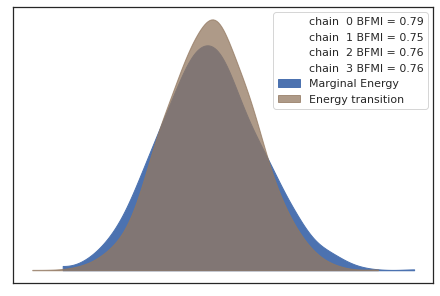

In [79]:
with AsfcModel as model:
    plotting_lib.pm.energyplot(trace_Asfc)

#### Posterior predictive distribution

In [80]:
with AsfcModel as model:
    posterior_pred_Asfc = pm.sample_posterior_predictive(trace_Asfc,samples=numPredSamples,random_seed=random_seed)

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


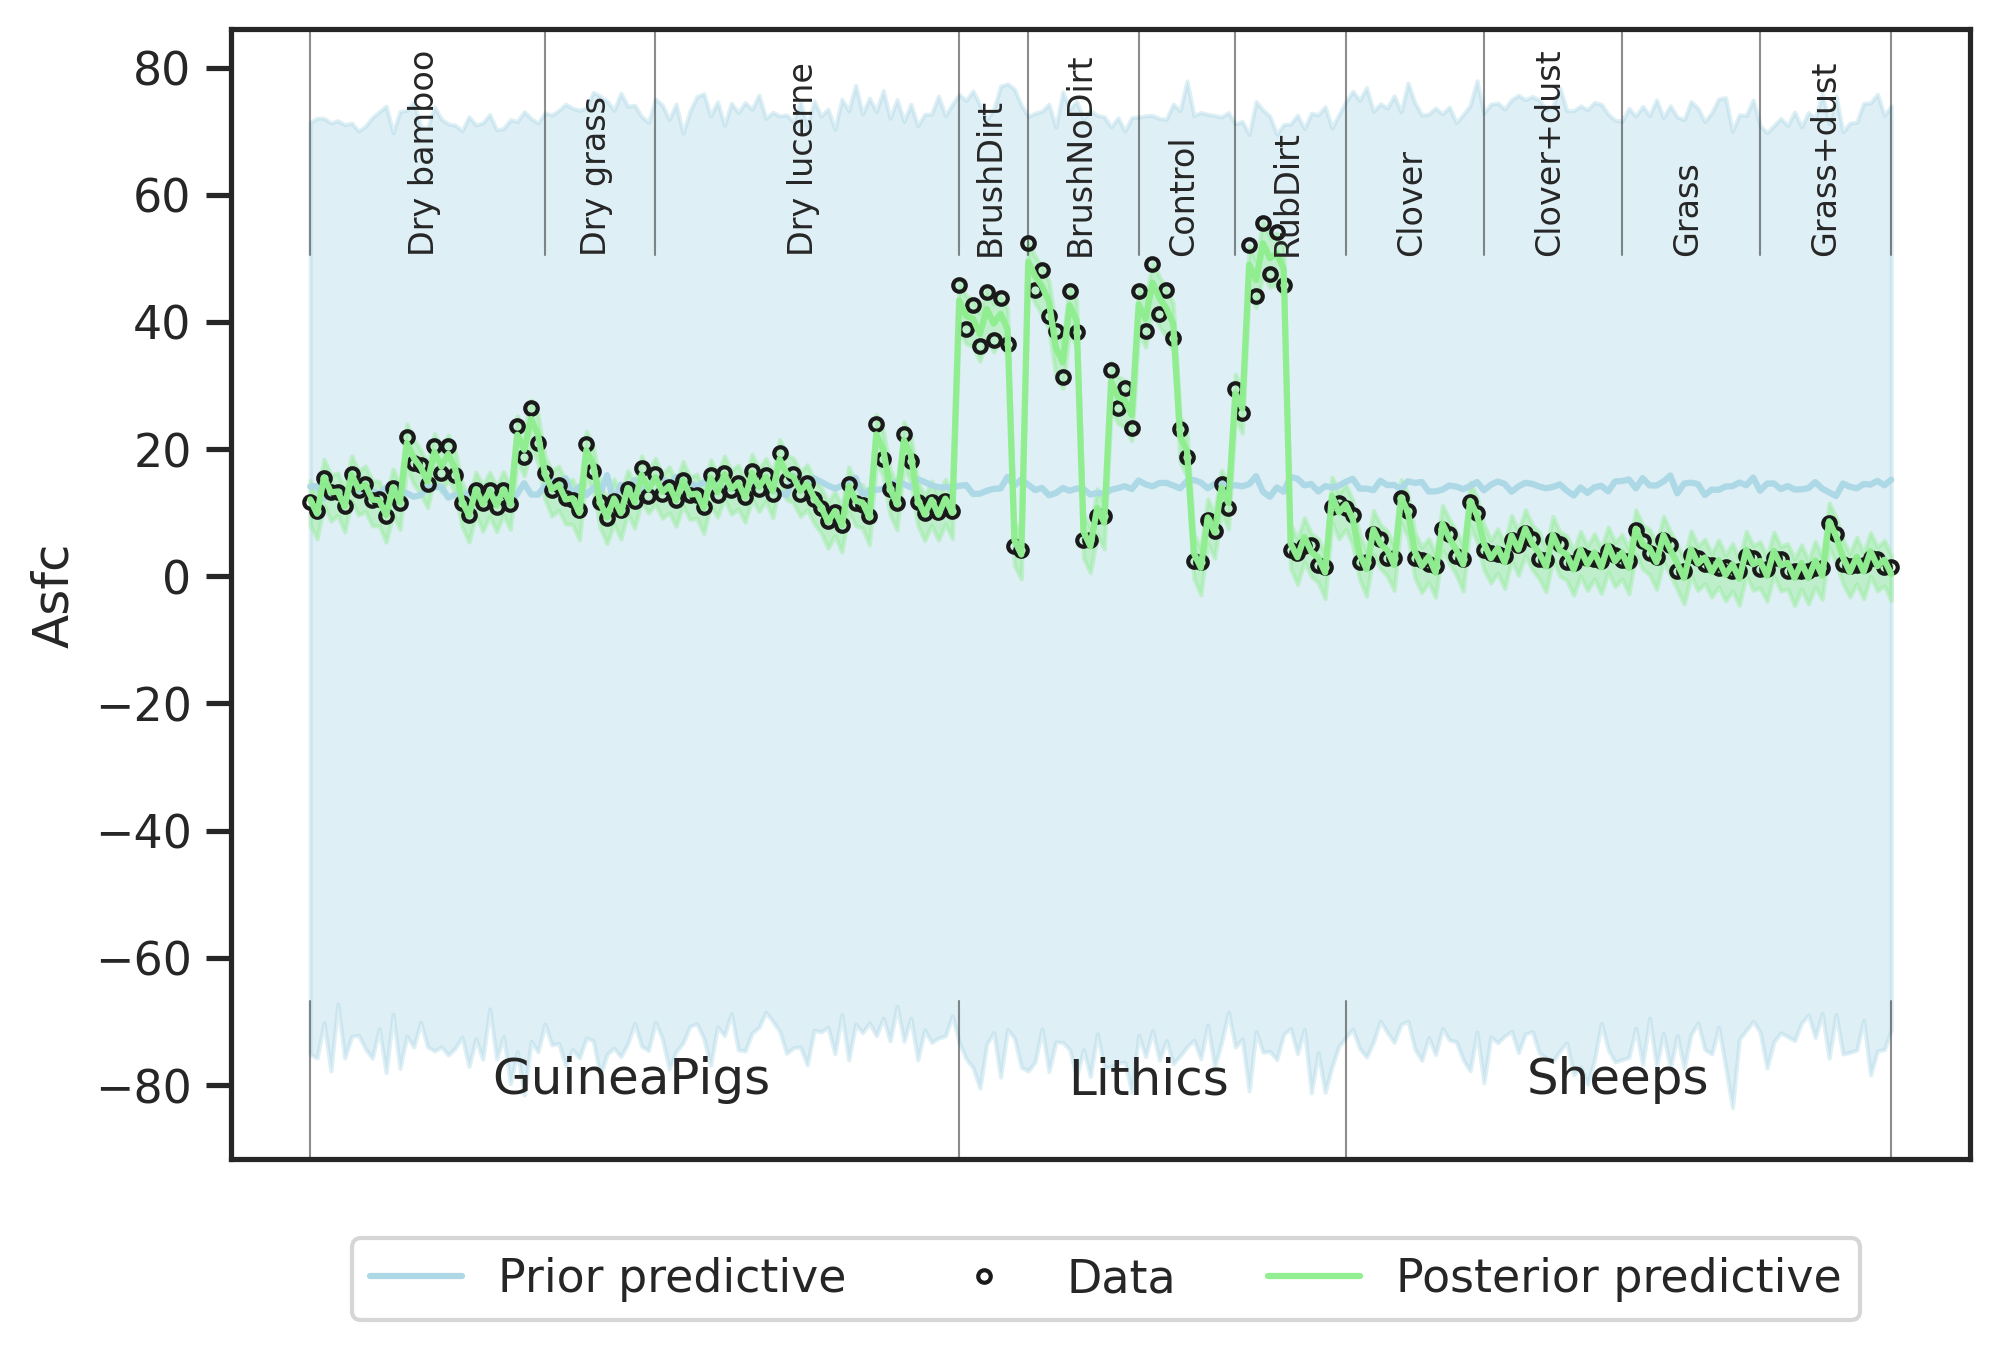

In [81]:
plotting_lib.plotPriorPosteriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,df,\
                                          dictMeanStd,prior_pred_Asfc,\
                                          posterior_pred_Asfc,dataZ["Asfc_z"].values,'Asfc',prefix)

#### Compare prior and posterior for model parameters

In [82]:
with AsfcModel as model:
    pm_data_Asfc = az.from_pymc3(trace=trace_Asfc,prior=prior_pred_Asfc,posterior_predictive=posterior_pred_Asfc)

arviz.data.io_pymc3 - WARNING - posterior predictive variable Asfc_y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


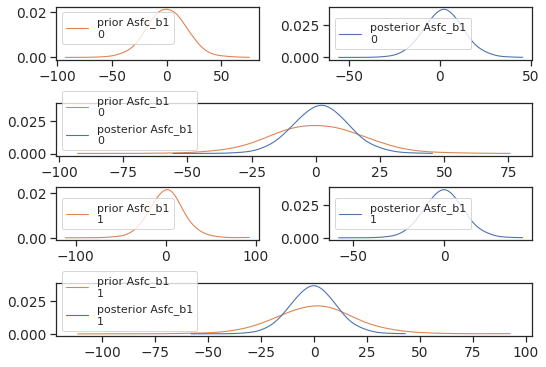

In [83]:
plotting_lib.plotPriorPosteriorB(widthInch,heigthInch,dpi,\
                                 sizes,writeOut,outPathPlots,dictMeanStd,pm_data_Asfc,'Asfc',prefix)

#### Posterior and contrasts

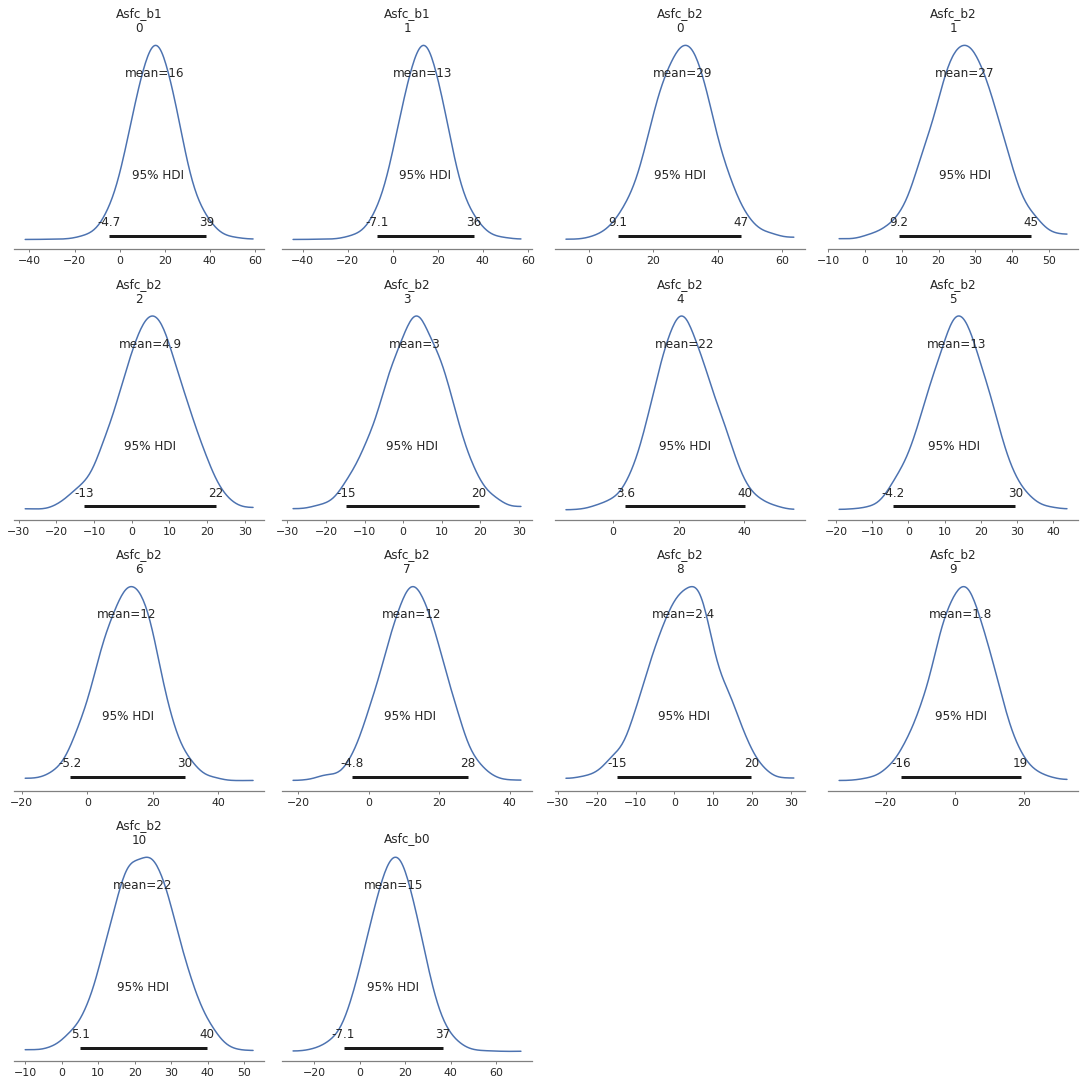

In [84]:
plotting_lib.plotPosterior(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,pm_data_Asfc,'Asfc',prefix)

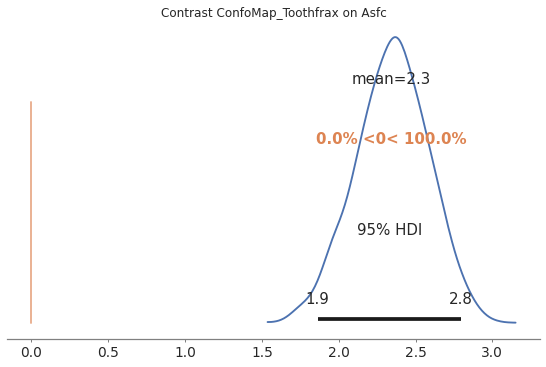

In [85]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                          x1contrast_dict,trace_Asfc,'Asfc',prefix)

### 	Smfc  <a name="Smfc"></a>

In [86]:
with pm.Model() as model:
    SmfcModel = ThreeFactorModel('Smfc',x1,x2,x3,dataZ.Smfc_z.values)

#### Verify model settings

In [87]:
SmfcModel.printParams(x1,x2,x3,dataZ.Smfc_z.values)

The number of levels of the x variables are (2, 11, 115)
The standard deviations used for the beta priors are (1.2914215627674575, 3.238203806583398, 9.733076513589282)


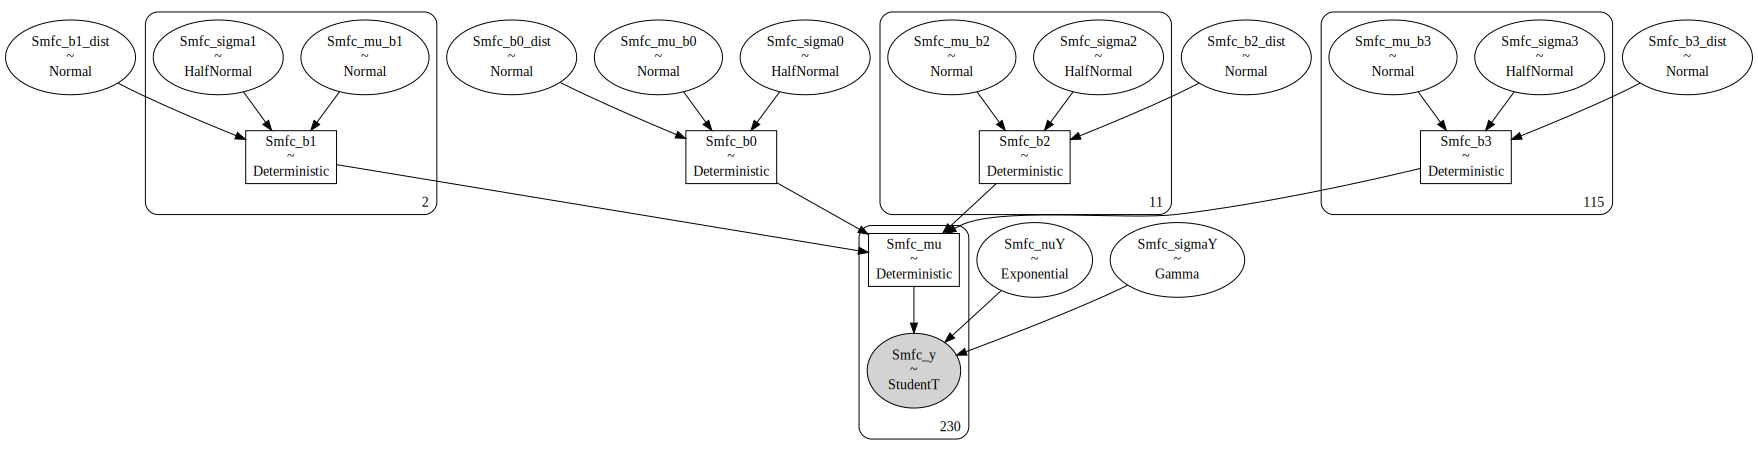

In [88]:
pm.model_to_graphviz(SmfcModel)

#### Check prior choice

In [89]:
with SmfcModel as model:
    prior_pred_Smfc = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

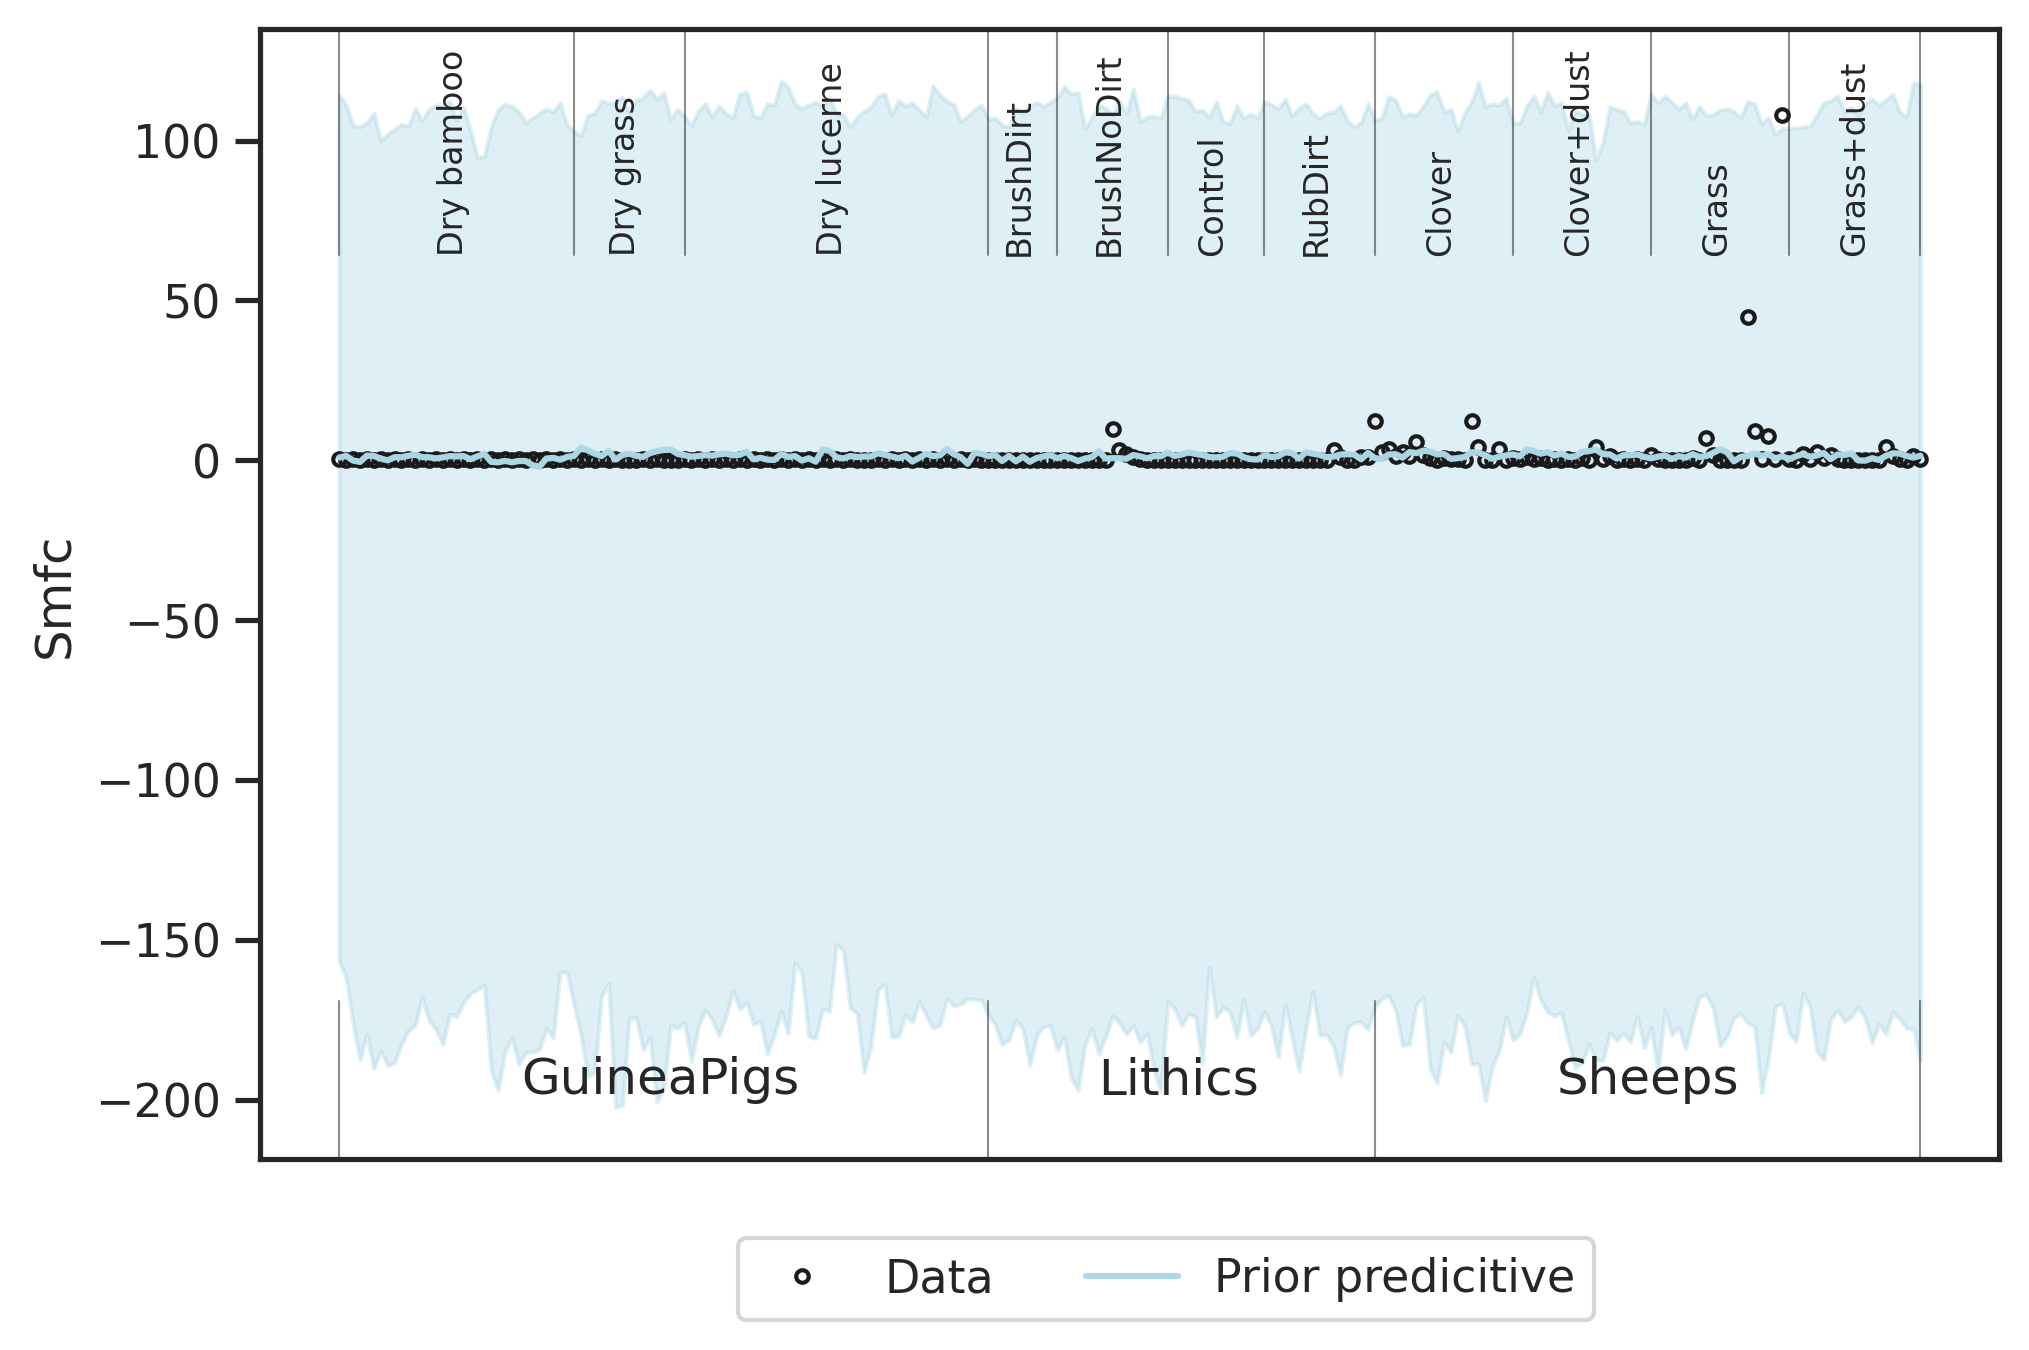

In [90]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,\
                                 df,dictMeanStd,prior_pred_Smfc,dataZ.Smfc_z.values,'Smfc',prefix)

Prior choice is as intended: Broad over the data range.

#### Sampling

In [91]:
with SmfcModel as model:
    trace_Smfc = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=0.8,random_seed=random_seed)
    #fit_Smfc = pm.fit(random_seed=random_seed)
    #trace_Smfc = fit_Smfc.sample(draws=numSamples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Smfc_b3_dist, Smfc_b2_dist, Smfc_b1_dist, Smfc_b0_dist, Smfc_sigmaY, Smfc_nuY, Smfc_mu_b3, Smfc_mu_b2, Smfc_mu_b1, Smfc_mu_b0, Smfc_sigma3, Smfc_sigma2, Smfc_sigma1, Smfc_sigma0]


ValueError: Not enough samples to build a trace.

Analysis stopped here because sampling did not converge.
As the plot shows, some data points are very far away from the others, which would require the analysis to be based on more heavy-tailed distributions.

### HAsfc9 <a name="HAsfc9"></a>

In [92]:
with pm.Model() as model:
    HAsfc9Model = ThreeFactorModel('HAsfc9',x1,x2,x3,dataZ["HAsfc9_z"].values)

#### Verify model settings

In [93]:
HAsfc9Model.printParams(x1,x2,x3,dataZ["HAsfc9_z"].values)

The number of levels of the x variables are (2, 11, 115)
The standard deviations used for the beta priors are (1.2761156280868398, 3.214359712024942, 5.469742884138536)


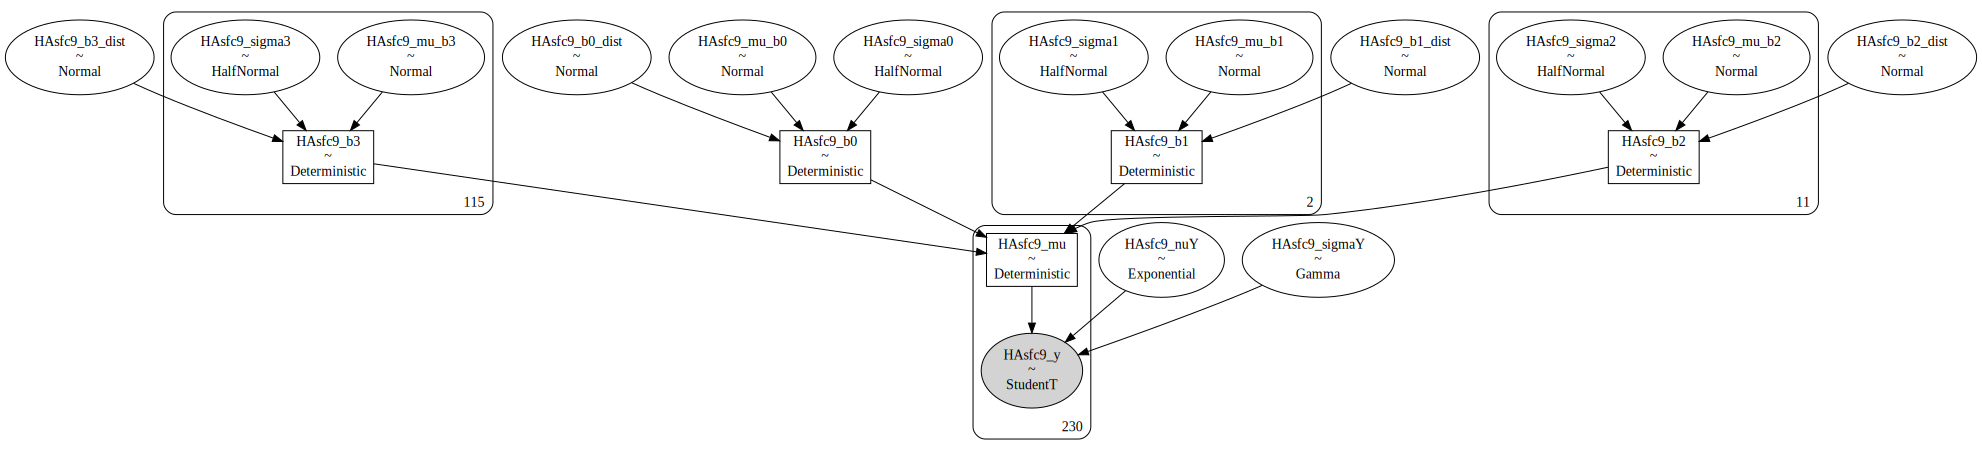

In [94]:
pm.model_to_graphviz(HAsfc9Model)

#### Check prior choice

In [95]:
with HAsfc9Model as model:
    prior_pred_HAsfc9 = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

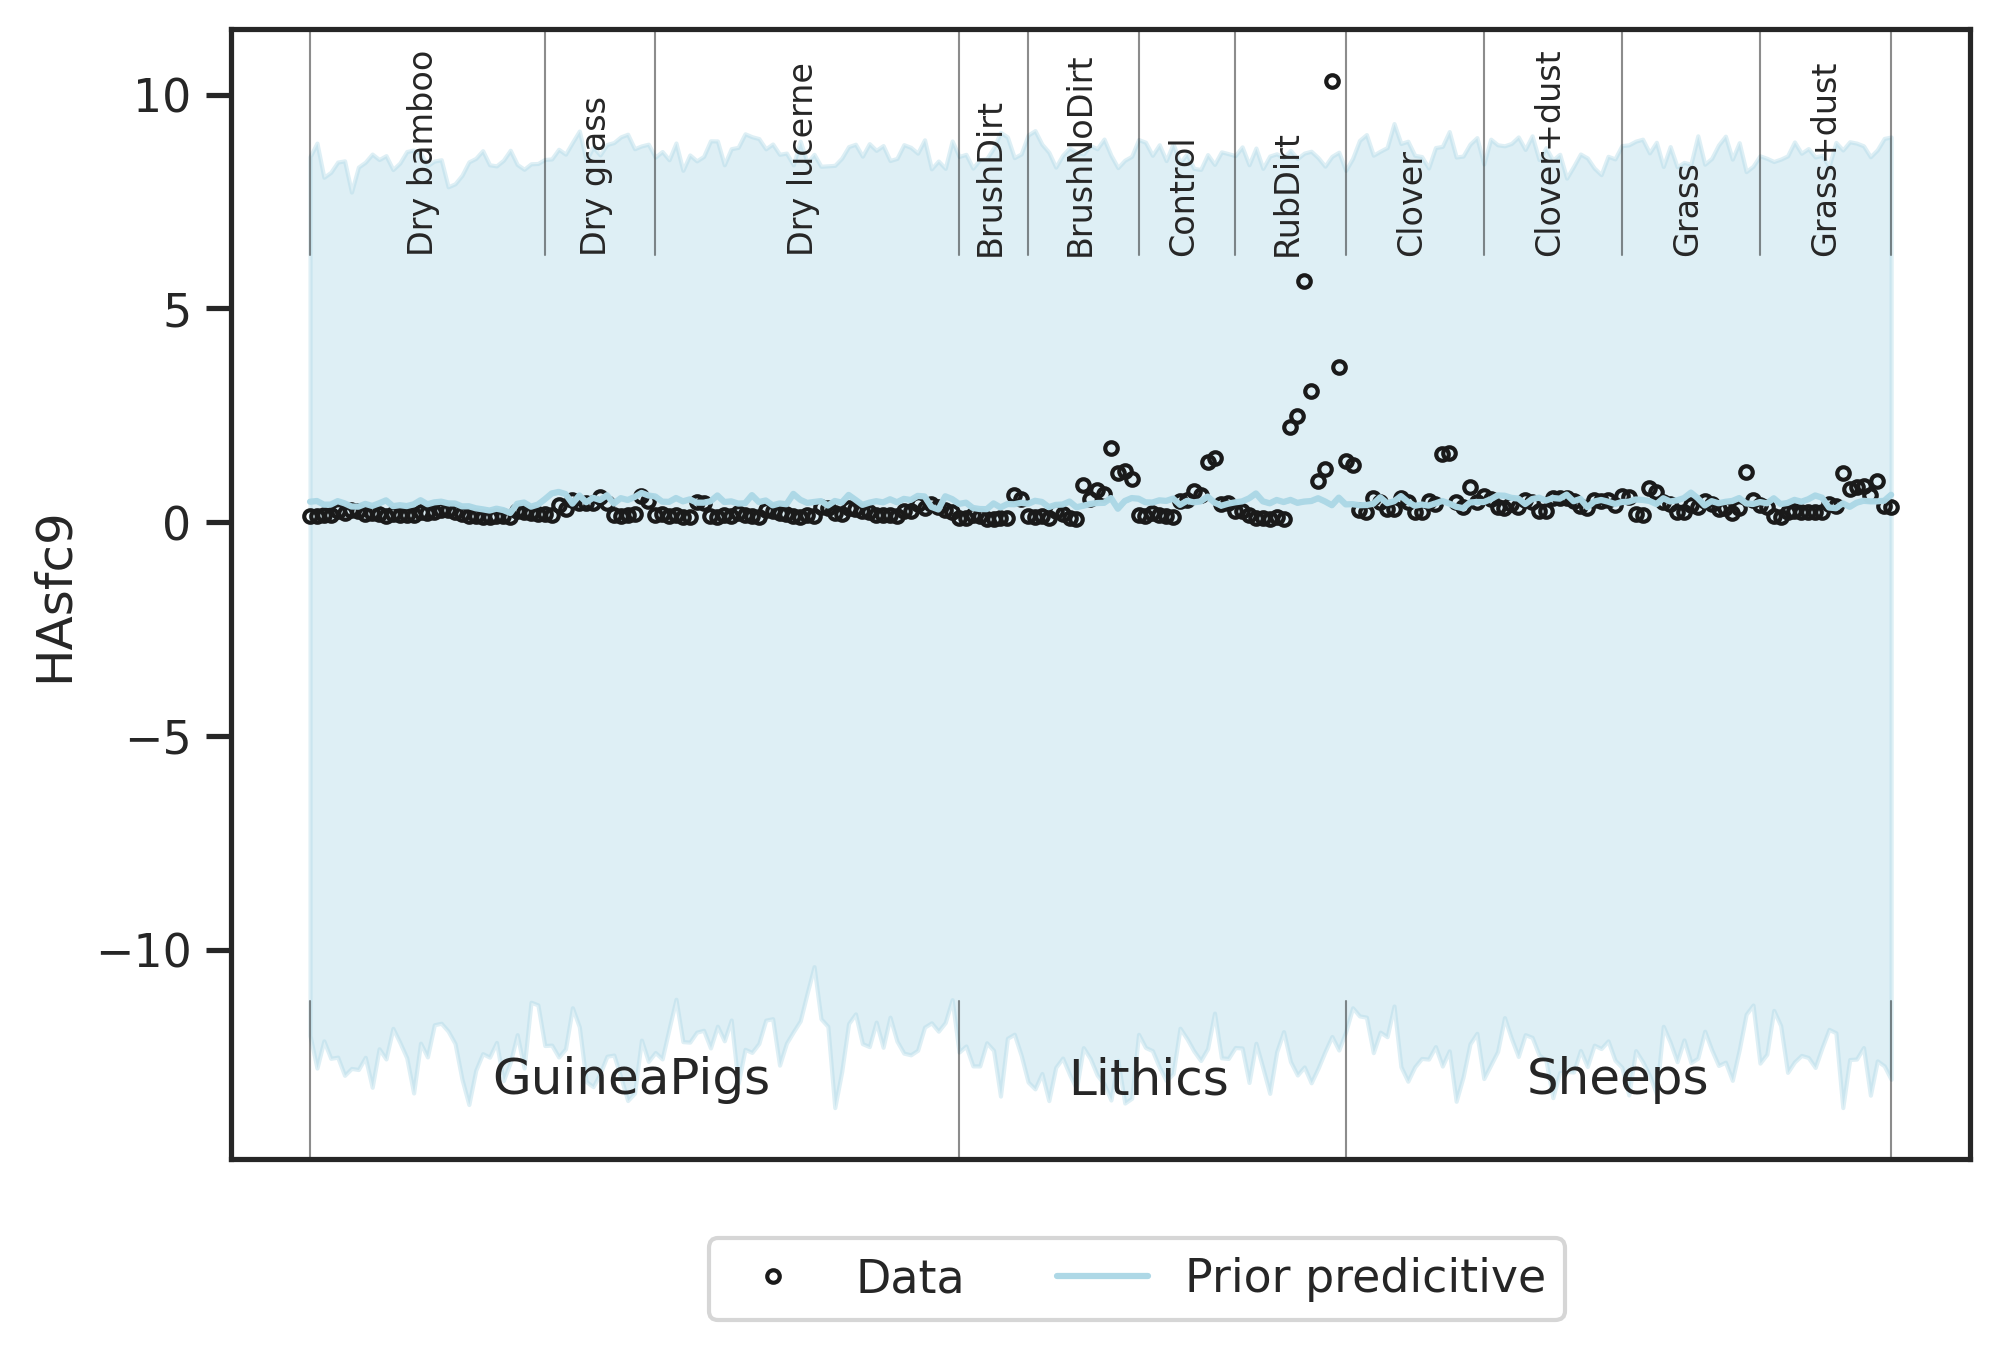

In [96]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,\
                                 writeOut,outPathPlots,df,dictMeanStd,\
                                 prior_pred_HAsfc9,dataZ["HAsfc9_z"].values,'HAsfc9',prefix)

Prior choice is as intended: Broad over the data range.

#### Sampling

In [97]:
with HAsfc9Model as model:
    trace_HAsfc9 = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=target_accept,random_seed=random_seed)
    #fit_HAsfc9 = pm.fit(random_seed=random_seed)
    #trace_HAsfc9 = fit_HAsfc9.sample(draws=numSamples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HAsfc9_b3_dist, HAsfc9_b2_dist, HAsfc9_b1_dist, HAsfc9_b0_dist, HAsfc9_sigmaY, HAsfc9_nuY, HAsfc9_mu_b3, HAsfc9_mu_b2, HAsfc9_mu_b1, HAsfc9_mu_b0, HAsfc9_sigma3, HAsfc9_sigma2, HAsfc9_sigma1, HAsfc9_sigma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4843 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [98]:
with HAsfc9Model as model:
    if writeOut:
        with open(outPathData + '{}_model_{}.pkl'.format(prefix,'HAsfc9'), 'wb') as buff:
            pickle.dump({'model': HAsfc9Model, 'trace': trace_HAsfc9}, buff)

#### Check sampling

In [99]:
with HAsfc9Model as model:
    dataTrace_HAsfc9 = az.from_pymc3(trace=trace_HAsfc9)

In [100]:
pm.summary(dataTrace_HAsfc9,hdi_prob=0.95).round(2)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
HAsfc9_mu_b0    -0.00  0.82     -1.68       1.55       0.01     0.01   
HAsfc9_mu_b1[0]  0.01  0.69     -1.33       1.34       0.01     0.01   
HAsfc9_mu_b1[1] -0.02  0.70     -1.38       1.35       0.01     0.01   
HAsfc9_mu_b2[0] -0.26  0.53     -1.35       0.72       0.01     0.01   
HAsfc9_mu_b2[1]  0.07  0.50     -0.90       1.07       0.01     0.01   
...               ...   ...       ...        ...        ...      ...   
HAsfc9_mu[225]   0.39  0.02      0.34       0.43       0.00     0.00   
HAsfc9_mu[226]   0.36  0.20      0.13       0.63       0.01     0.01   
HAsfc9_mu[227]   0.33  0.20      0.10       0.59       0.01     0.01   
HAsfc9_mu[228]  -0.13  0.02     -0.16      -0.10       0.00     0.00   
HAsfc9_mu[229]  -0.16  0.02     -0.19      -0.13       0.00     0.00   

                 ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
HAsfc9_mu_b0       3782.0  2036.0    3779.0    2689.0   1.00  
HAsfc9_mu_b1[0]    4279.0  2197.0    4390.0    3117.0   1.00  
HAsfc9_mu_b1[1]    4028.0  2107.0    4063.0    2662.0   1.00  
HAsfc9_mu_b2[0]    2143.0  2124.0    2150.0    2808.0   1.00  
HAsfc9_mu_b2[1]    2457.0  2386.0    2444.0    2855.0   1.00  
...                   ...     ...       ...       ...    ...  
HAsfc9_mu[225]     4042.0  4035.0    3933.0    3252.0   1.00  
HAsfc9_mu[226]      288.0   288.0     455.0    3073.0   1.01  
HAsfc9_mu[227]      288.0   288.0     451.0    3108.0   1.01  
HAsfc9_mu[228]     5325.0  2741.0    3907.0    3274.0   1.00  
HAsfc9_mu[229]     5295.0  2994.0    3852.0    3338.0   1.00  

[623 rows x 11 columns]

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:216: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


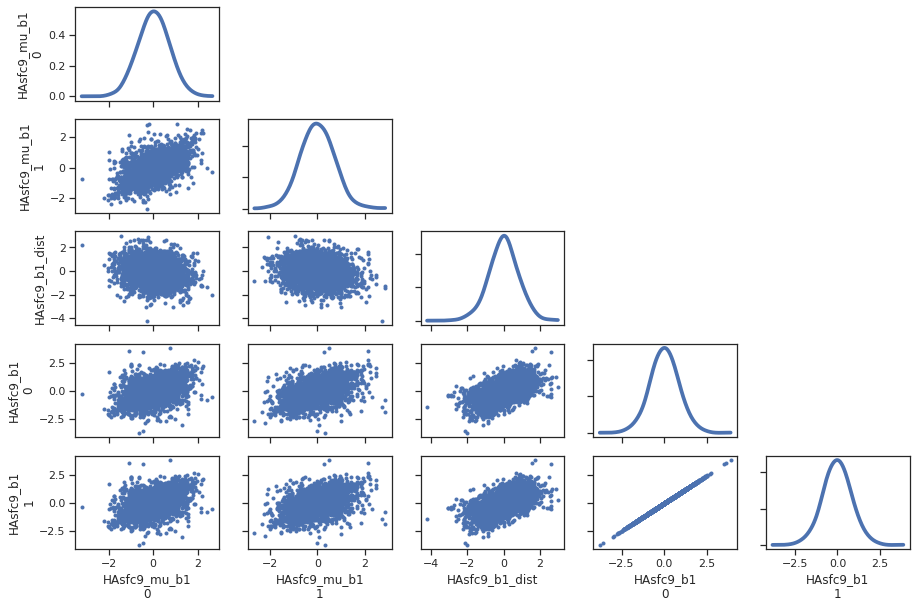

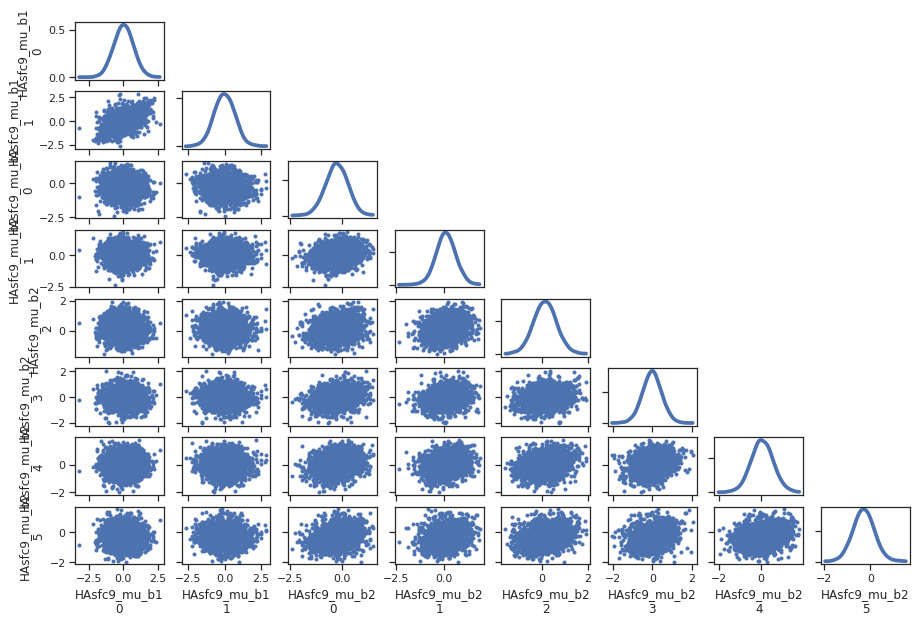

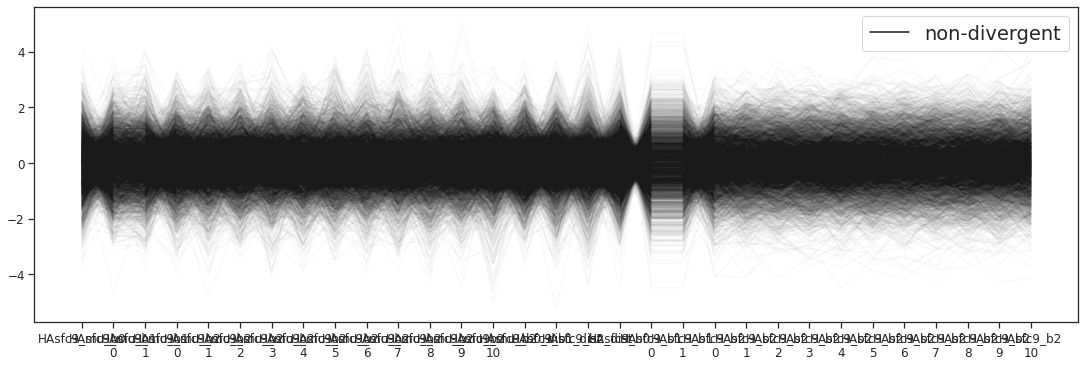

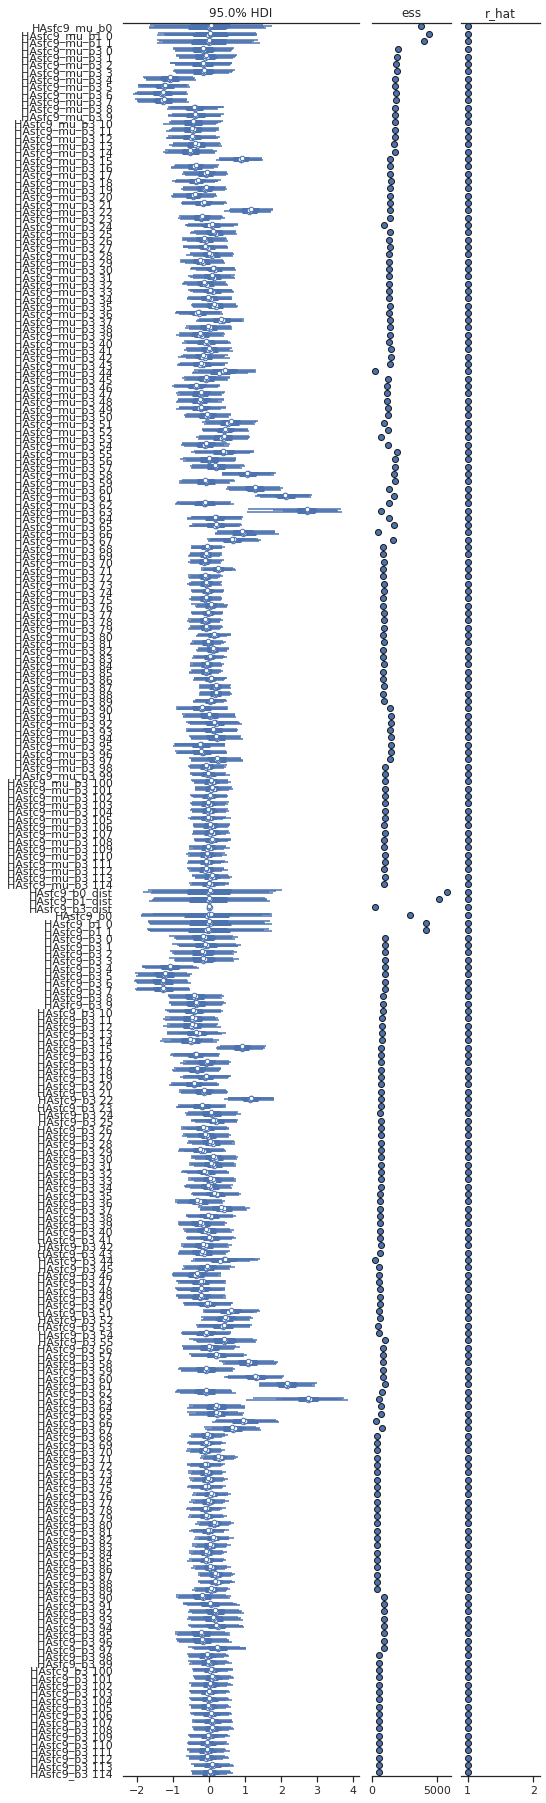

In [101]:
plotting_lib.plotDiagnostics(widthInch,heigthInch,dpi,writeOut,\
                             outPathPlots,trace_HAsfc9,dataTrace_HAsfc9,'HAsfc9',prefix)

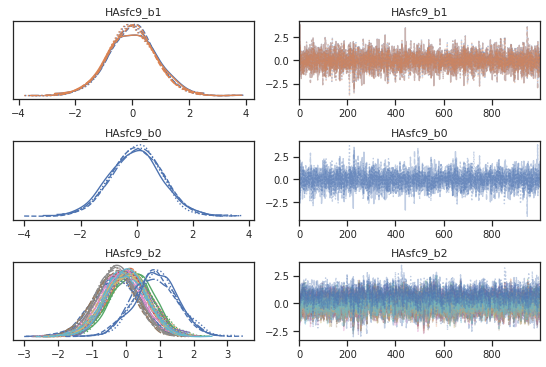

In [102]:
with HAsfc9Model as model:
    plotting_lib.plotTracesB(widthInch,heigthInch,dpi,writeOut,outPathPlots,trace_HAsfc9,'HAsfc9',prefix)

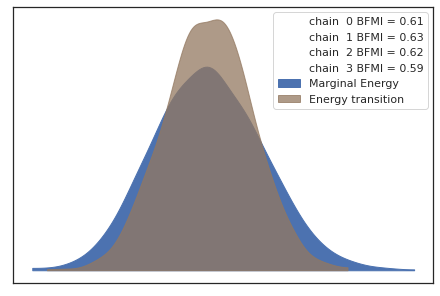

In [103]:
with HAsfc9Model as model:
    plotting_lib.pm.energyplot(trace_HAsfc9)

#### Posterior predictive distribution

In [104]:
with HAsfc9Model as model:
    posterior_pred_HAsfc9 = pm.sample_posterior_predictive(trace_HAsfc9,samples=numPredSamples,random_seed=random_seed)

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


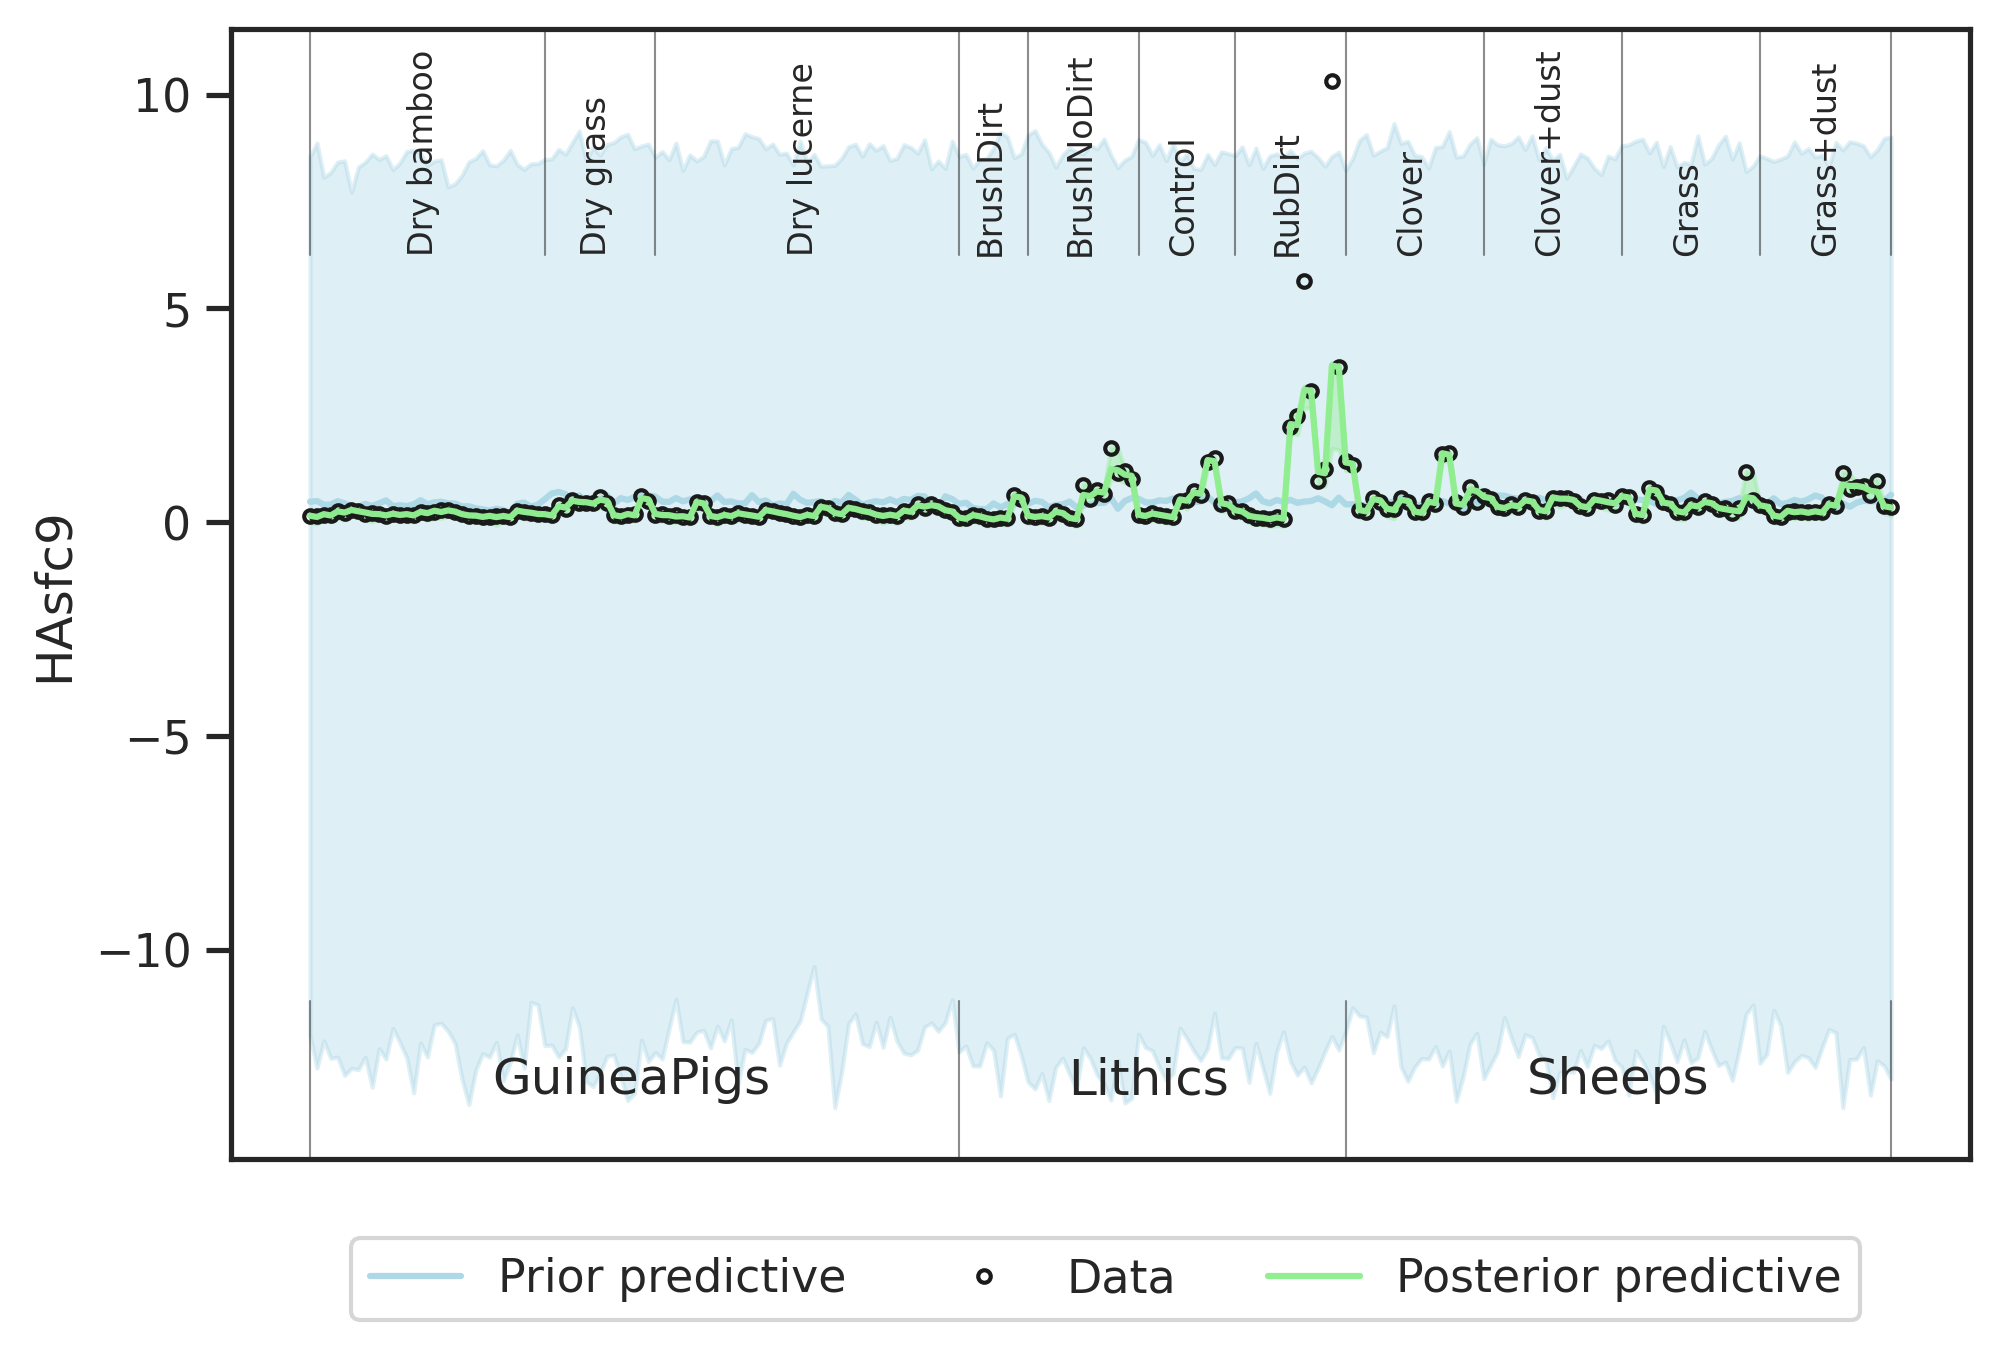

In [105]:
plotting_lib.plotPriorPosteriorPredictive(widthInch,heigthInch,dpi,writeOut,\
                                          outPathPlots,df,dictMeanStd,prior_pred_HAsfc9,posterior_pred_HAsfc9,\
                                          dataZ["HAsfc9_z"].values,'HAsfc9',prefix)

#### Compare prior and posterior for model parameters

In [106]:
with HAsfc9Model as model:
    pm_data_HAsfc9 = az.from_pymc3(trace=trace_HAsfc9,prior=prior_pred_HAsfc9,posterior_predictive=posterior_pred_HAsfc9)

arviz.data.io_pymc3 - WARNING - posterior predictive variable HAsfc9_y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


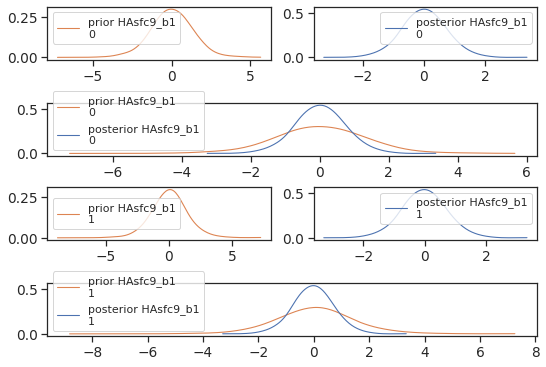

In [107]:
plotting_lib.plotPriorPosteriorB(widthInch,heigthInch,dpi,sizes,writeOut,outPathPlots,\
                                 dictMeanStd,pm_data_HAsfc9,'HAsfc9',prefix)

#### Posterior and contrasts

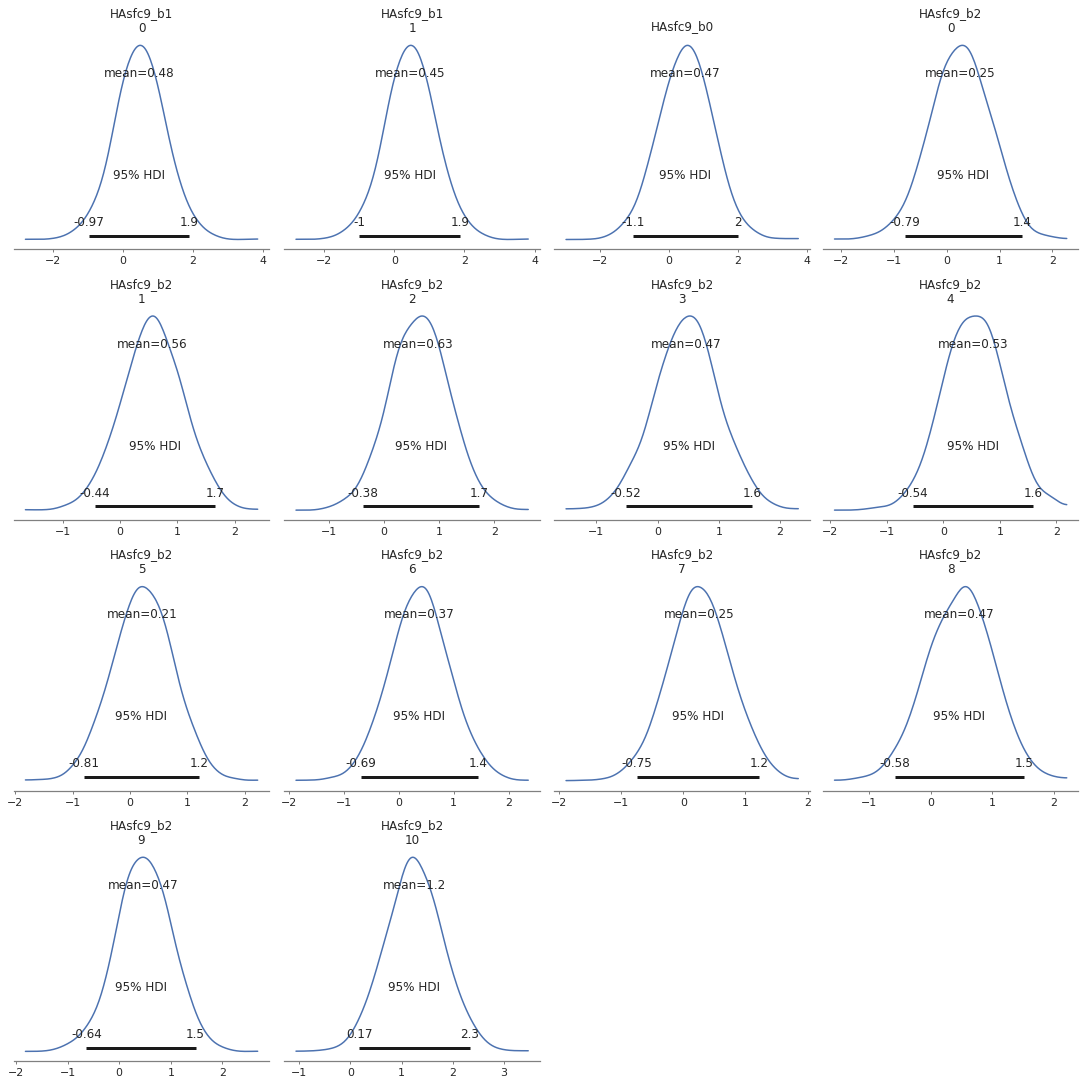

In [108]:
plotting_lib.plotPosterior(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,pm_data_HAsfc9,'HAsfc9',prefix)

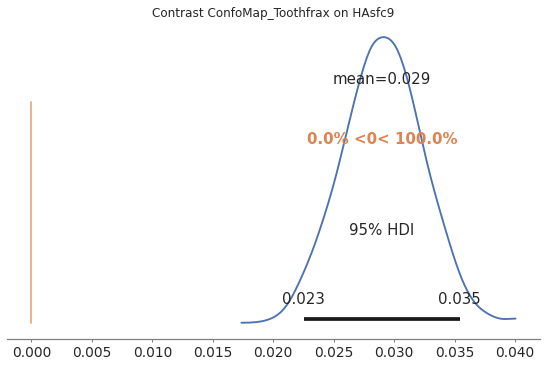

In [109]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd\
                          ,x1contrast_dict,trace_HAsfc9,'HAsfc9',prefix)

## Summary <a name="summary"></a>
The contrast plots between the two software packages are shown below again for each variable except Smfc

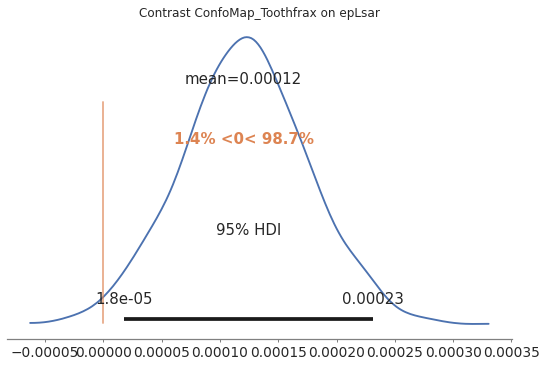

In [110]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                          x1contrast_dict,trace_epLsar,'epLsar',prefix)

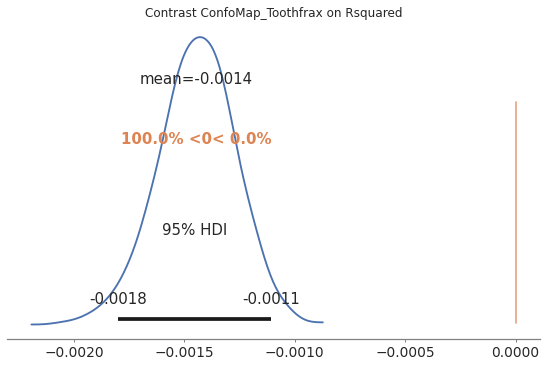

In [111]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                          x1contrast_dict,trace_Rsquared,'Rsquared',prefix)

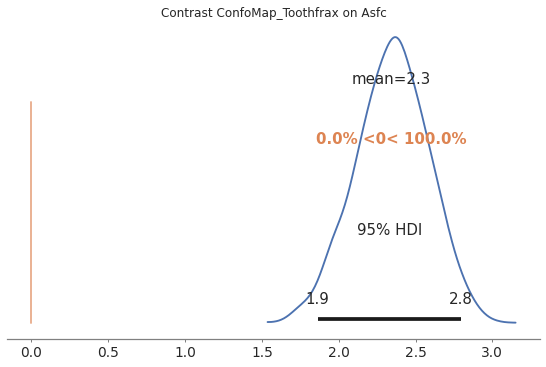

In [112]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                          x1contrast_dict,trace_Asfc,'Asfc',prefix)

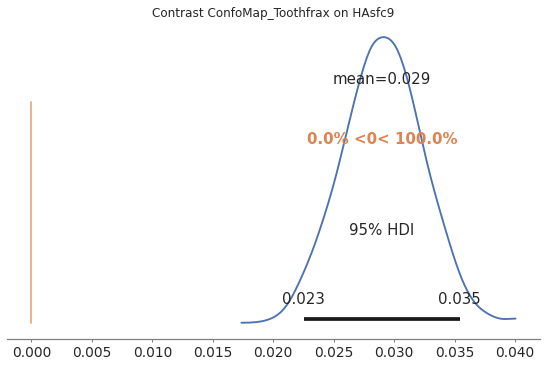

In [113]:
plotting_lib.plotContrast(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,\
                          x1contrast_dict,trace_HAsfc9,'HAsfc9',prefix)

### Write out

In [114]:
!jupyter nbconvert --to html Statistical_Model_ThreeFactor_filter_strong.ipynb

[NbConvertApp] Converting notebook Statistical_Model_ThreeFactor_filter_strong.ipynb to html
[NbConvertApp] Writing 9166948 bytes to Statistical_Model_ThreeFactor_filter_strong.html


In [115]:
!jupyter nbconvert --to markdown Statistical_Model_ThreeFactor_filter_strong.ipynb

[NbConvertApp] Converting notebook Statistical_Model_ThreeFactor_filter_strong.ipynb to markdown
[NbConvertApp] Support files will be in Statistical_Model_ThreeFactor_filter_strong_files/
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_ThreeFactor_filter_stron